# Exploratory Data Analysis - Lipinksi's rule for the FDA New Chemical Entities (1997-2021)

After manually curated the dataset (merged from FDA database and DrugBank database) we are going the explore the Lipinski's rules of the ~560 New Chemical Entitities approved by the <b>FDA</b>. About 30 SMILES were manually gathered since none of the two strategies worked (SMILES from name structures or automatically merged with the DrugBank database).

First we need to import the libraries used in this analysis, which is mainly composed of rdkit (to manipulate the structures) and pandas/searborn to do the data analysis.

In [1]:
from rdkit import Chem, rdBase
from rdkit.Chem import Draw, Descriptors, PandasTools, AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.SaltRemover import SaltRemover, InputFormat

import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.linear_model import LinearRegression
import session_info

import matplotlib
from matplotlib.patches import Rectangle
from matplotlib.text import OffsetFrom
import matplotlib.pyplot as plt

## 1) Loading the and treating the dataset

Now, we load the database in the csv format. The database was converted to excel and carefully curated: each of the SMILES double checked, most  of the salts removed and was done by GHMS and ACGS.

In [2]:
# We read the raw data
drugs = pd.read_csv("/home/arturcgs/HDD/Documents/mestrado/datasets/lipinski/fda_small_molecules_smiles.csv")

# Selecting the dataframe without the index that came from the file
drugs = drugs.iloc[:,2:]
drugs.head(3)

,active_ingredient_moiety,nda_bla,approval_year,active,DrugBank ID,Drug Groups,SMILES,Name,Drug Type
0,troglitazone,NDA,1997,troglitazone,DB00197,approved; investigational; withdrawn,CC1=C(C)C2=C(CCC(C)(COC3=CC=C(CC4SC(=O)NC4=O)C...,Troglitazone,SmallMoleculeDrug
1,imiquimod,NDA,1997,imiquimod,DB00724,approved; investigational,CC(C)CN1C=NC2=C1C1=C(C=CC=C1)N=C2N,Imiquimod,SmallMoleculeDrug
2,anagrelide hydrochloride,NDA,1997,anagrelide,DB00261,approved,ClC1=CC=C2N=C3NC(=O)CN3CC2=C1Cl,Anagrelide,SmallMoleculeDrug


In [3]:
print(drugs.shape)
drugs[(drugs["SMILES"] == "Not found")]

(560, 9)


,active_ingredient_moiety,nda_bla,approval_year,active,DrugBank ID,Drug Groups,SMILES,Name,Drug Type
533,colesevelam hydrochloride,NDA,2000,colesevelam,DB00930,approved,Not found,Colesevelam,SmallMoleculeDrug
535,tinzaparin sodium,NDA,2000,tinzaparin,DB06822,approved,Not found,Tinzaparin,SmallMoleculeDrug
548,kunecatechins,NDA,2006,kunecatechins,DB01266,nutraceutical,Not found,Sinecatechins,SmallMoleculeDrug
551,gadofosveset trisodium,NDA,2008,gadofosveset,DB06705,contrast,Not found,Gadofosveset trisodium,SmallMoleculeDrug
556,sulfur hexafluoride lipid-type A microspheres,NDA,2014,sulfur hexafluoride lipid-type A microspheres,DB11104,approved,Not found,Sulfur hexafluoride,SmallMoleculeDrug
557,sodium zirconium cyclosilicate,NDA,2018,zirconium cyclosilicate,DB14048,approved,Not found,Sodium zirconium cyclosilicate,SmallMoleculeDrug


### 1.1) Initial cleaning and prep

First, we need to do some cleaning job on the dataset. We need to remove some of the salts  and do some double checking on the stuff. Now we perform the <b>SALT CLEANING</b> and the deionization of the respective base.

We begin by converting the SMILES into the mol format for further analysis

In [4]:
# correcting the Brilliant Blue G Ophthalmic Solution (it was unreadable)
brilliant_blue_smiles = '[Na+].CCOC1=CC=C(NC2=CC=C(C=C2)C(=C2\C=C/C(/C=C2C)=[N+](/CC)CC2=CC(=CC=C2)S([O-])(=O)=O)\C2=C(C)C=C(C=C2)N(CC)CC2=CC(=CC=C2)S([O-])(=O)=O)C=C1'

drugs.iloc[559,6] = brilliant_blue_smiles
drugs.iloc[559,:]

active_ingredient_moiety                 Brilliant Blue G Ophthalmic Solution
nda_bla                                                                   NDA
approval_year                                                            2019
active                                   Brilliant Blue G Ophthalmic Solution
DrugBank ID                                                           DB15594
Drug Groups                                                          approved
SMILES                      [Na+].CCOC1=CC=C(NC2=CC=C(C=C2)C(=C2\C=C/C(/C=...
Name                                                         Brilliant blue G
Drug Type                                                   SmallMoleculeDrug
Name: 559, dtype: object

In [5]:
# Removing the "Not Found" SMILES. The SMILES were almost all manually curated in order to gather as many structures as possible
drugs_db = drugs.loc[~(drugs["SMILES"] == "Not found")]
print(drugs_db.shape)
# Adding the ROMol Column, which is the proper format (mol) for further calculations
PandasTools.AddMoleculeColumnToFrame(drugs_db, "SMILES")

(554, 9)


[11:32:11] Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [11:32:11] Explicit valence for atom # 0 N, 4, is greater than permitted
/home/arturcgs/miniconda3/envs/teachopencadd/lib/python3.8/site-packages/rdkit/Chem/PandasTools.py:422: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[molCol] = frame[smilesCol].map(Chem.MolFromSmiles)


Then, we make a function to clean the salts from the database. The selected ions were Cl, Br, Na, K and Gd (mainly from contrast structures)

In [6]:
# defining the salts we want to remove from the database
remover = SaltRemover(defnData="[Cl,Br,Na,K,Gd]")

# Defining the function to neutralize the atoms in organic molecules
def neutralize_atoms(mol):
    pattern = Chem.MolFromSmarts("[+1!h0!$([*]~[-1,-2,-3,-4]),-1!$([*]~[+1,+2,+3,+4])]")
    at_matches = mol.GetSubstructMatches(pattern)
    at_matches_list = [y[0] for y in at_matches]
    if len(at_matches_list) > 0:
        for at_idx in at_matches_list:
            atom = mol.GetAtomWithIdx(at_idx)
            chg = atom.GetFormalCharge()
            hcount = atom.GetTotalNumHs()
            atom.SetFormalCharge(0)
            atom.SetNumExplicitHs(hcount - chg)
            atom.UpdatePropertyCache()
    return mol

In order to advance into the curation process we need to remove any non-readable or innappropriate smile/structure. We can do this and simutaneously stripping the salts using the function `StripMol()` that uses the `remover.SaltRemover()` function defined earlier.

In [7]:
mols = [] # creating an empty list

## FUNCTION FOR CHECKING THE NON READABLE:

# Creating a loop to 1) convert from smiles to mol and use the `remover.StripMol() on each structure
for i, smi in enumerate(drugs_db.SMILES):
    try:
        mol = Chem.MolFromSmiles(smi) # converting to a proper format
        mol = remover.StripMol(mol) # stripping the salts
        mols.append(mol) # appending to a list
    except:
        print(smi,i) # printing the exceptions, or the non-readable smiles and the respective index

RDKit ERROR: [11:32:12] Explicit valence for atom # 0 N, 4, is greater than permitted
[11:32:12] Explicit valence for atom # 0 N, 4, is greater than permitted


[H][N]1([H])[C@@H]2CCCC[C@H]2[N]([H])([H])[Pt]11OC(=O)C(=O)O1 124


We can see that our database has some non-readable smiles that can cause some problems further in the future. We can remove the by doing the `drop()` method allied to `.index[]`.

In [8]:
drugs_db.shape

(554, 10)

In [9]:
# dropping the structures found to be non-readable
drugs_db = drugs_db.drop([drugs_db.index[124]]).reset_index(drop=True)

# dropping biotech molecule found manually
drugs_db = drugs_db.drop([drugs_db.index[304]]).reset_index(drop=True) #biological/polymer
drugs_db = drugs_db.drop([drugs_db.index[529]]).reset_index(drop=True) #biological/polymer
drugs_db = drugs_db.drop([drugs_db.index[526]]).reset_index(drop=True) #biological/polymer
drugs_db = drugs_db.drop([drugs_db.index[31]]).reset_index(drop=True) #talc

In [10]:
drugs_db.shape

(549, 10)







We can check again to see if any of the non-readable smiles still lingers on our dataset:

In [11]:
# Running the same function again (it's better to define a function and just call it again...)
mols = []
for i, smi in enumerate(drugs_db.SMILES):
    try:
        mol = Chem.MolFromSmiles(smi)
        mol = remover.StripMol(neutralize_atoms(mol))
        mols.append(mol)
    except:
        print(smi,i)

Since there is no structure printed, we can conclude that all the smiles left can be properly converted to mol. We are now able to perform the `remover.StripMol()` and `neutralize_atoms()` at our .mol column,

### 1.2) Removing the salts and neutralizing the organic molecules

Using the `apply` method on the column and performing the functions `StripMol` and `neutralize_atoms`

In [12]:
# removing the salts
drugs_db["Mol_Clean"] = drugs_db.ROMol.apply(remover.StripMol)

# neutralizing atoms O- goes to OH and so on..
drugs_db["Mol_Clean"] = drugs_db.Mol_Clean.apply(neutralize_atoms)

### 1.3) Calculation of the descriptors

We can see that our method cannot handle to much inorganic information such as the case of talc.

Now we calculate the descritptors: Molecular Weight, Number of Hydrogen Acceptors, Number of Hydrogen Donors and LogP that we need to compute the statistcs of the drugs. But first we need to transform the smiles to "mol" format.

In [13]:
drugs_db["mw"] = drugs_db["Mol_Clean"].apply(Descriptors.ExactMolWt)
drugs_db["n_hba"] = drugs_db["Mol_Clean"].apply(Descriptors.NumHAcceptors)
drugs_db["n_hbd"] = drugs_db["Mol_Clean"].apply(Descriptors.NumHDonors)
drugs_db["logp"] = drugs_db["Mol_Clean"].apply(Descriptors.MolLogP)

### Merging the dosage and route form dataset

In [14]:
# We begin by merging the drugs_db and the actives_route datasets in order to get the route

active_route = pd.read_csv("/home/arturcgs/HDD/Documents/mestrado/datasets/lipinski/active_route_final.csv")

active_route = active_route[["active_stripped", "Route_Unique"]]

Taking a look at the dataset we are able to see that everything seems ok we have to rename the active_stripped to active to merge both datasets.

In [15]:
print(f'The active_route dataset has the shape {active_route.shape}')

#Renaming the active_stripped column to active:
active_route.rename(columns = {"active_stripped": "active"}, inplace = True)

active_route.head(4)

The active_route dataset has the shape (856, 2)


,active,Route_Unique
0,abacavir,oral
1,abaloparatide,subcutaneous
2,abemaciclib,oral
3,abiraterone,oral


In [16]:
drugs_db_with_route = pd.merge(drugs_db, active_route, how = "left", on = "active")

drugs_db_with_route.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 549 entries, 0 to 548
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   active_ingredient_moiety  549 non-null    object 
 1   nda_bla                   549 non-null    object 
 2   approval_year             549 non-null    int64  
 3   active                    549 non-null    object 
 4   DrugBank ID               549 non-null    object 
 5   Drug Groups               549 non-null    object 
 6   SMILES                    549 non-null    object 
 7   Name                      545 non-null    object 
 8   Drug Type                 545 non-null    object 
 9   ROMol                     549 non-null    object 
 10  Mol_Clean                 549 non-null    object 
 11  mw                        549 non-null    float64
 12  n_hba                     549 non-null    int64  
 13  n_hbd                     549 non-null    int64  
 14  logp      

In [17]:
drugs_db_with_route[["active", "DrugBank ID", "Route_Unique"]].to_csv("/home/arturcgs/HDD/Documents/mestrado/datasets/drugs_db_with_route.csv", index=False)

After creating the `drugs_db_with_route` we did some manually completion of the remaining route of administration and now we're going to import it and merge the remaining routes.

In [18]:
# We load the dataset 
drugs_db_with_route_manually = pd.read_csv("/home/arturcgs/HDD/Documents/mestrado/datasets/lipinski/drugs_db_with_route_manually_final.csv")

# Selecting only active and Route_Unique
drugs_db_with_route_manually = drugs_db_with_route_manually[["active", "Route_Unique"]]

# Renaming the Route_Unique to Route only
drugs_db_with_route_manually.rename(columns = {"Route_Unique": "route"}, inplace = True)

print(drugs_db_with_route_manually.shape)
drugs_db_with_route_manually.head(10)

(551, 2)


,active,route
0,troglitazone,oral
1,imiquimod,topical
2,anagrelide,oral
3,nelfinavir,oral
4,delavirdine,oral
5,tamsulosin,oral
6,toremifene,oral
7,tazarotene,topical
8,cerivastatin,oral
9,pramipexole,oral


### Merging the datasets route and SMILES and descriptors

,active_ingredient_moiety,nda_bla,approval_year,active,DrugBank ID,Drug Groups,SMILES,Name,Drug Type,ROMol,Mol_Clean,mw,n_hba,n_hbd,logp,route
0,troglitazone,NDA,1997,troglitazone,DB00197,approved; investigational; withdrawn,CC1=C(C)C2=C(CCC(C)(COC3=CC=C(CC4SC(=O)NC4=O)C...,Troglitazone,SmallMoleculeDrug,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",441.160994,6,2,4.37426,oral
1,imiquimod,NDA,1997,imiquimod,DB00724,approved; investigational,CC(C)CN1C=NC2=C1C1=C(C=CC=C1)N=C2N,Imiquimod,SmallMoleculeDrug,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",240.137497,4,1,2.82270,topical
2,anagrelide hydrochloride,NDA,1997,anagrelide,DB00261,approved,ClC1=CC=C2N=C3NC(=O)CN3CC2=C1Cl,Anagrelide,SmallMoleculeDrug,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",254.996617,3,1,1.92630,oral
3,nelfinavir mesylate,NDA,1997,nelfinavir,DB00220,approved,[H][C@@]12CCCC[C@]1([H])CN(C[C@@H](O)[C@H](CSC...,Nelfinavir,SmallMoleculeDrug,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",567.313078,6,4,4.74762,oral
4,delavirdine mesylate,NDA,1997,delavirdine,DB00705,approved,CC(C)NC1=C(N=CC=C1)N1CCN(CC1)C(=O)C1=CC2=C(N1)...,Delavirdine,SmallMoleculeDrug,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",456.194360,6,3,2.71710,oral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544,gadoterate meglumine,NDA,2013,gadoterate meglumine,DB09132,approved,[Gd+3].CNC[C@H](O)[C@@H](O)[C@H](O)[C@H](O)CO....,Gadoteric acid,SmallMoleculeDrug,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",599.301387,14,10,-5.81190,intravenous
545,dimethyl fumarate,NDA,2013,dimethyl fumarate,DB08908,approved; investigational,[H]\C(=C(\[H])C(=O)OC)C(=O)OC,Dimethyl fumarate,SmallMoleculeDrug,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",144.042259,4,0,-0.11140,oral
546,dalbavancin,NDA,2014,dalbavancin,DB06219,approved; investigational,CN[C@H]1C(=O)N[C@@H]2Cc3ccc(Oc4cc5cc(Oc6ccc(cc...,Dalbavancin,SmallMoleculeDrug,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",1814.608558,29,21,4.16800,intravenous
547,tafamidis meglumine,NDA,2019,tafamidis meglumine,DB11644,approved; investigational,OC(=O)C1=CC=C2N=C(OC2=C1)C1=CC(Cl)=CC(Cl)=C1,Tafamidis,SmallMoleculeDrug,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",306.980298,3,1,4.49980,oral

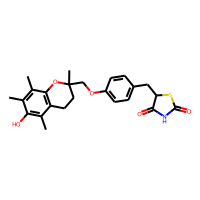
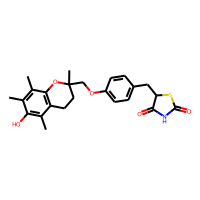
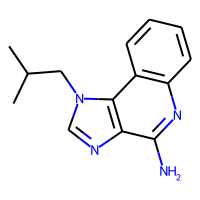
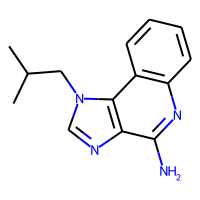
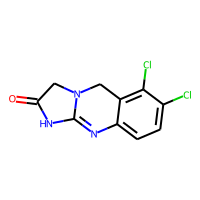
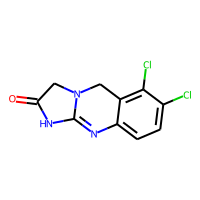
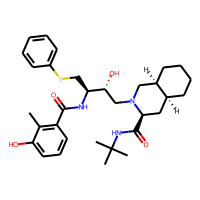
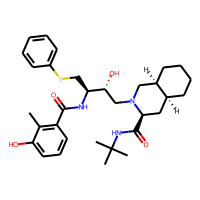
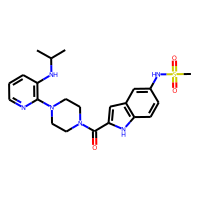
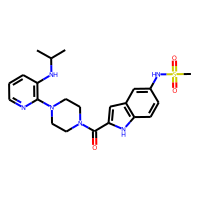
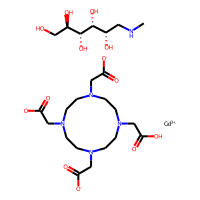
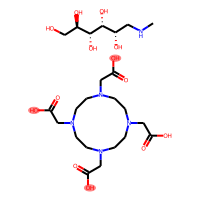
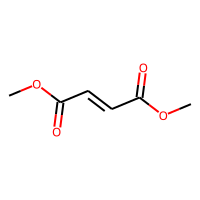
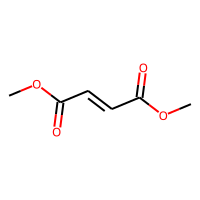
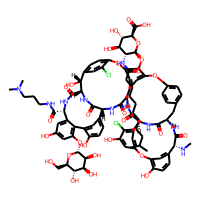
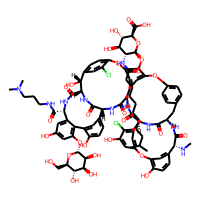
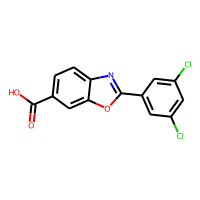
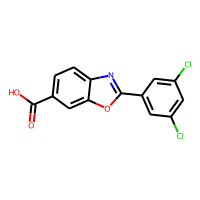
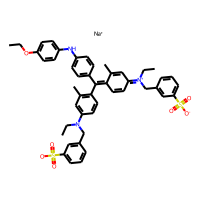
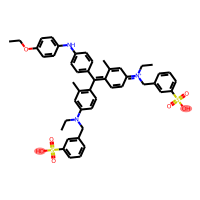

In [19]:
# Merging the datasets (with curated)
drugs_db_route_merged = pd.merge(drugs_db_with_route, drugs_db_with_route_manually, how = "left", on = "active")

# Dropping the Route_Unique columns that has 
drugs_db_route_merged = drugs_db_route_merged.drop(["Route_Unique"], axis = 1)

# Drugs 
drugs_db_route_merged

In [20]:
drugs_db_route_merged.shape

(549, 16)

,active_ingredient_moiety,nda_bla,approval_year,active,DrugBank ID,Drug Groups,SMILES,Name,Drug Type,ROMol,Mol_Clean,mw,n_hba,n_hbd,logp,route
526,eptifibatide,NDA,1998,eptifibatide,DB00063,approved; investigational,NC(N)=NCCCCC1NC(=O)CCSSCC(NC(=O)C2CCCN2C(=O)C(...,NaN,NaN,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",831.315614,11,10,-2.05440,NaN
529,unoprostone isopropyl,NDA,2000,unoprostone isopropyl,DBSALT001760,approved,CCCCCCCC(=O)CC[C@H]1[C@@H](C[C@@H]([C@@H]1C/C=...,NaN,NaN,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",424.318875,5,2,5.12230,NaN
531,cefditoren pivoxil,NDA,2001,cefditoren pivoxil,DBSALT001811,approved,[H][C@]12SCC(\C=C/C3=C(C)N=CS3)=C(N1C(=O)[C@H]...,NaN,NaN,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",620.118160,14,2,2.29812,NaN
535,pentetate calcium trisodium,NDA,2004,pentetate,DB06806,approved,[O-]C(=O)CN(CCN(CC([O-])=O)CC([O-])=O)CCN(CC([...,NaN,NaN,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",393.138344,8,5,-2.68460,NaN

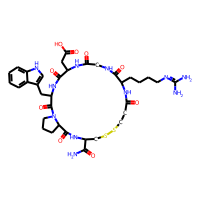
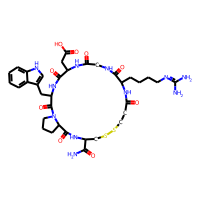
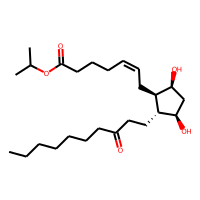
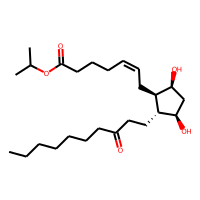
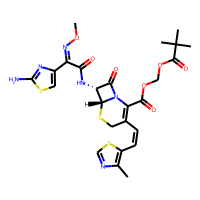
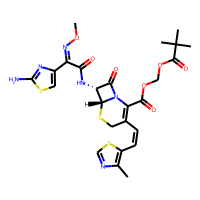
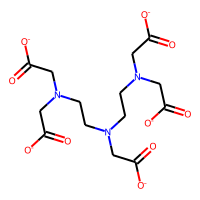
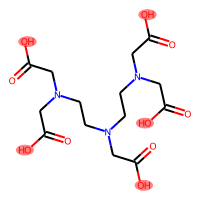

In [21]:
drugs_db_route_merged[drugs_db_route_merged["route"].isna()]

We complete manually the not-found routes as below:

In [22]:
drugs_db_route_merged.loc[529,"route"] = "intravenous"
drugs_db_route_merged.loc[533, "route"] = "ophthalmic"
drugs_db_route_merged.loc[535,"route"] = "oral"
drugs_db_route_merged.loc[539,"route"] = "intravenous"

### Removing the drug groups that has biological

In [23]:
biological = drugs_db_route_merged["Drug Groups"].str.contains(pat = "biological|polymer")
drugs_db_route_merged = drugs_db_route_merged[~biological].reset_index(drop = True)

In [24]:
drugs_db_route_merged.shape

(549, 16)

After removing the drugs that is in the biological groups we are left with 550 structures

### Creating DataFrame with only drugs with oral route of admninistration

(360, 16)


,active_ingredient_moiety,nda_bla,approval_year,active,DrugBank ID,Drug Groups,SMILES,Name,Drug Type,ROMol,Mol_Clean,mw,n_hba,n_hbd,logp,route
0,troglitazone,NDA,1997,troglitazone,DB00197,approved; investigational; withdrawn,CC1=C(C)C2=C(CCC(C)(COC3=CC=C(CC4SC(=O)NC4=O)C...,Troglitazone,SmallMoleculeDrug,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",441.160994,6,2,4.37426,oral
2,anagrelide hydrochloride,NDA,1997,anagrelide,DB00261,approved,ClC1=CC=C2N=C3NC(=O)CN3CC2=C1Cl,Anagrelide,SmallMoleculeDrug,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",254.996617,3,1,1.92630,oral
3,nelfinavir mesylate,NDA,1997,nelfinavir,DB00220,approved,[H][C@@]12CCCC[C@]1([H])CN(C[C@@H](O)[C@H](CSC...,Nelfinavir,SmallMoleculeDrug,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",567.313078,6,4,4.74762,oral
4,delavirdine mesylate,NDA,1997,delavirdine,DB00705,approved,CC(C)NC1=C(N=CC=C1)N1CCN(CC1)C(=O)C1=CC2=C(N1)...,Delavirdine,SmallMoleculeDrug,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",456.194360,6,3,2.71710,oral
5,tamsulosin hydrochloride,NDA,1997,tamsulosin,DB00706,approved; investigational,CCOC1=CC=CC=C1OCCN[C@H](C)CC1=CC(=C(OC)C=C1)S(...,Tamsulosin,SmallMoleculeDrug,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",408.171893,6,2,2.34090,oral

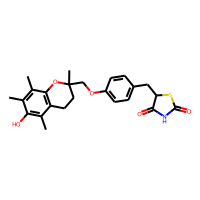
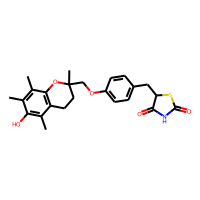
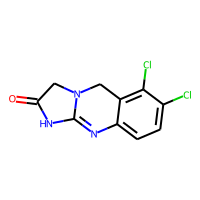
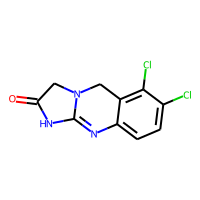
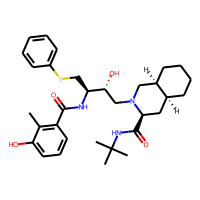
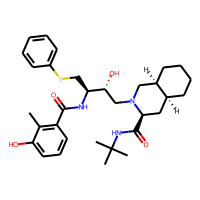
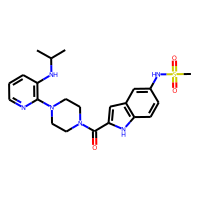
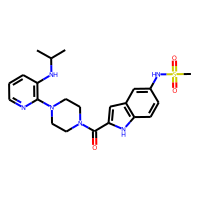
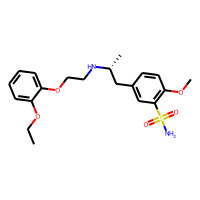
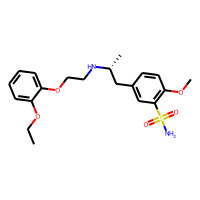

In [25]:
# separating the db

drugs_oral = drugs_db_route_merged[drugs_db_route_merged.route == 'oral'].copy()
print(drugs_oral.shape)
drugs_oral.head()

There has been 360 FDA approved SMALL drugs with oral admnistration, from 1997 to 2021

### Saving Dataset

In [26]:
drugs_db_route_merged.to_csv("/home/arturcgs/HDD/Documents/mestrado/datasets/lipinski/approved_drugs_final.csv", index=False)

## 2) Basic data visualization and exploration

Since the plots are probably going to be published, this is a very good strategy: to set the context with the seaborn function `set_context()`, which automatically does the job of increasing the datapoints and fonts to yield a better visualization 

In [27]:
drugs_db_route_merged.shape

(549, 16)

In [28]:
sns.set_context("talk")
pd.options.display.max_colwidth = 1000

The following chunks of code are related to the basic plots of distribution of the lipinski's rule:

- A molecular mass less than 500 daltons
- No more than 5 hydrogen bond donors (the total number of nitrogen–hydrogen and oxygen–hydrogen bonds)
- No more than 10 hydrogen bond acceptors (all nitrogen or oxygen atoms)
- An octanol-water partition coefficient(log P) that does not exceed 5

Now we're finally able to do the analysis of the data. We have done so far the 1) Cleaning and prep proces 2) Curation of the structres by salt removing and neutralizing the organic molecules. Below we are going to explore each of the calculated descriptors.

In [29]:
print(f' The median of n_hbd of all the period is {drugs_db_route_merged["n_hbd"].median()}')
print(f' The median of n_hbd of all the period is {drugs_db_route_merged["n_hba"].median()}')
print(f' The median of molecular weight of all the period is {drugs_db_route_merged["mw"].median()}')
print(f' The median of logp of all the period is {drugs_db_route_merged["logp"].median()}')

 The median of n_hbd of all the period is 2.0
 The median of n_hbd of all the period is 6.0
 The median of molecular weight of all the period is 426.136428192
 The median of logp of all the period is 3.0835000000000017


In [30]:
color_palette = {
    "bars": "#264653",
    "patch": "g",
    "arrow": "g",
    "vline": "#e76f51",
    "countplot_bar1": "#264653",
    "countplot_bar2": "#387a6c"
}

In [31]:
def dist_graph(df, col_name, title, xlabel, binwidth, threshold, xlim, ax, fig):
    
    dist = sns.histplot(
        data = df, 
        x = col_name, 
        color = color_palette["bars"], 
        binwidth = binwidth,
        linewidth=2
    )
    ax.axvline(threshold,color = color_palette["vline"], linestyle = "--")
    ax.set_xlim(*xlim) # setting the xlim
    fig.suptitle(title, fontsize = 22, fontweight=1000)
    dist.set_title("FDA approved drugs (1997-2021)", fontsize=18, fontweight=1000)
    dist.set_xlabel(xlabel, fontweight=1000, fontsize=18)
    dist.set_ylabel("")

    # tick sizes and bold
    plt.setp(ax.get_xticklabels(), fontsize=20, fontweight=627)
    plt.setp(ax.get_yticklabels(), fontsize=20, fontweight=624)

    # adding a shaded region
    ax.add_patch(Rectangle((-100, 0),
                            threshold+100, 5000,
                            fc =color_palette["patch"], 
                            ec ='none',
                            lw = 10, alpha = .1))

### 2.1) Molecular Weight distribution

Plotting the molecular weight distribution:

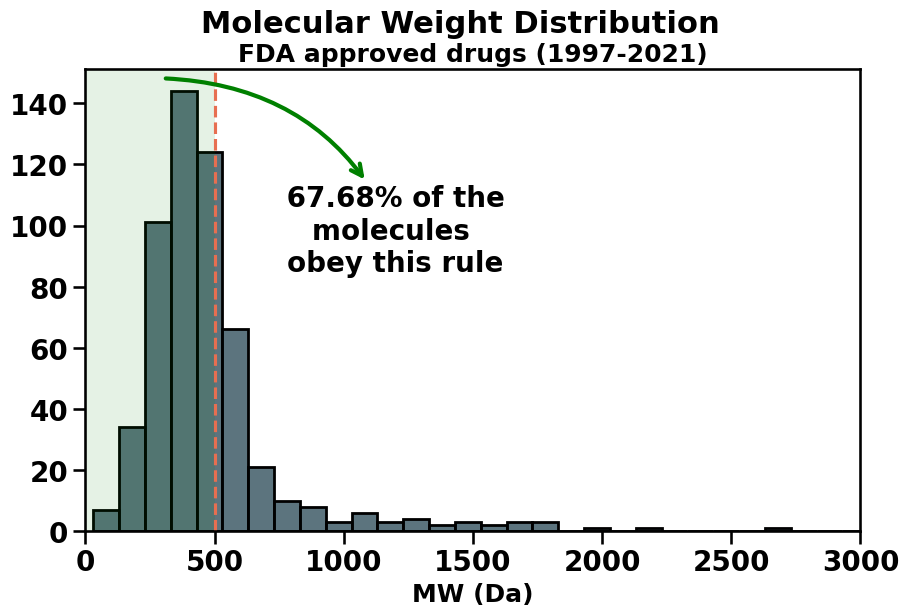

In [32]:
fig, ax = plt.subplots(figsize = (10,6))

dist_graph(
    df=drugs_db_route_merged, 
    col_name="mw", 
    title="Molecular Weight Distribution", 
    xlabel="MW (Da)", 
    binwidth=100, 
    threshold=500, 
    xlim=(0, 3000), 
    ax=ax, 
    fig=fig
)


# annotating the information about how % obey the lipinski's rules
param = ((drugs_db_route_merged.mw <=500).sum())/drugs.shape[0]

ax.annotate(f' {param:.2%} of the \nmolecules \nobey this rule',
            xy=(0.1, 0.98), xycoords='axes fraction',
            xytext=(0.4, 0.75), textcoords='axes fraction',
            arrowprops={"arrowstyle":"<-", "color":color_palette["arrow"], "lw":3, "connectionstyle":"arc3,rad=0.3"},
            verticalalignment='top', fontsize=20, fontweight=1000,
            horizontalalignment="center")
# saving plot
fig.savefig("../imgs/lipinski/dist_mw.png", dpi=300)

We are going to take a look at the strucres with more than 2000 Da. Printing them and their respective <b>SMILES FOR FURTHER ANALYSIS:</b>

In [33]:
pd.option_context.displaymax_colwidth = 5000 # we have to set the context in order to print all the characters in the smiles columns 

mol_2000_investigate = drugs_db_route_merged[drugs_db_route_merged.mw >= 2000]

print(f'SHAPE: {mol_2000_investigate.shape}')
(mol_2000_investigate[["active","SMILES", "DrugBank ID", "Drug Groups"]])

SHAPE: (5, 16)


,active,SMILES,DrugBank ID,Drug Groups
98,bivalirudin,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CC(O)=O)NC(=O)CNC(=O)[C@H](CC(N)=O)NC(=O)CNC(=O)CNC(=O)CNC(=O)CNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=N)NC(=O)[C@@H]1CCCN1C(=O)[C@H](N)CC1=CC=CC=C1)C(=O)N1CCC[C@H]1C(=O)N[C@@H](CCC(O)=O)C(=O)N[C@@H](CCC(O)=O)C(=O)N[C@@H](CC1=CC=C(O)C=C1)C(=O)N[C@@H](CC(C)C)C(O)=O,DB00006,approved; investigational
164,ziconotide,[H][C@]12CSSC[C@]3([H])NC(=O)[C@H](CCCCN)NC(=O)[C@H](C)NC(=O)CNC(=O)[C@H](CCCCN)NC(=O)CNC(=O)[C@H](CCCCN)NC(=O)[C@@H](N)CSSC[C@]([H])(NC(=O)[C@]([H])(CSSC[C@H](NC(=O)[C@H](CCCCN)NC(=O)CNC(=O)[C@H](CO)NC(=O)[C@H](CCCNC(N)=N)NC1=O)C(N)=O)NC(=O)[C@H](CC(O)=O)NC(=O)[C@H](CC1=CC=C(O)C=C1)NC(=O)[C@H](CCSC)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCCNC(N)=N)NC(=O)[C@H](CO)NC3=O)C(=O)N[C@@]([H])([C@@H](C)O)C(=O)NCC(=O)N[C@@H](CO)C(=O)N2,DB06283,approved
167,pramlintide,[H]N[C@@H](CCCCN)C(=O)N[C@H]1CSSC[C@H](NC(=O)[C@@]([H])(NC(=O)[C@H](C)NC(=O)[C@@]([H])(NC(=O)[C@H](CC(N)=O)NC1=O)[C@@H](C)O)[C@@H](C)O)C(=O)N[C@@H](C)C(=O)N[C@@]([H])([C@@H](C)O)C(=O)N[C@@H](CCC(N)=O)C(=O)N[C@@H](CCCNC(N)=N)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](C)C(=O)N[C@@H](CC(N)=O)C(=O)N[C@@H](CC1=CC=CC=C1)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](C(C)C)C(=O)N[C@@H](CC1=CN=CN1)C(=O)N[C@@H](CO)C(=O)N[C@@H](CO)C(=O)N[C@@H](CC(N)=O)C(=O)N[C@@H](CC(N)=O)C(=O)N[C@@H](CC1=CC=CC=C1)C(=O)NCC(=O)N1CCC[C@H]1C(=O)N[C@@]([H])([C@@H](C)CC)C(=O)N[C@@H](CC(C)C)C(=O)N1CCC[C@H]1C(=O)N1CCC[C@H]1C(=O)N[C@@]([H])([C@@H](C)O)C(=O)N[C@@H](CC(N)=O)C(=O)N[C@@H](C(C)C)C(=O)NCC(=O)N[C@@H](CO)C(=O)N[C@@H](CC(N)=O)C(=O)N[C@@]([H])([C@@H](C)O)C(=O)N[C@@H](CC1=CC=C(O)C=C1)C(N)=O,DB01278,approved; investigational
364,sugammadex,O[C@@H]1[C@@H](O)[C@@H]2O[C@H]3O[C@H](CSCCC(O)=O)[C@@H](O[C@H]4O[C@H](CSCCC(O)=O)[C@@H](O[C@H]5O[C@H](CSCCC(O)=O)[C@@H](O[C@H]6O[C@H](CSCCC(O)=O)[C@@H](O[C@H]7O[C@H](CSCCC(O)=O)[C@@H](O[C@H]8O[C@H](CSCCC(O)=O)[C@@H](O[C@H]9O[C@H](CSCCC(O)=O)[C@@H](O[C@H]1O[C@@H]2CSCCC(O)=O)[C@H](O)[C@H]9O)[C@H](O)[C@H]8O)[C@H](O)[C@H]7O)[C@H](O)[C@H]6O)[C@H](O)[C@H]5O)[C@H](O)[C@H]4O)[C@H](O)[C@H]3O,DB06206,approved
398,semaglutide,CC[C@H](C)[C@H](NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CCCCNC(=O)COCCOCCNC(=O)COCCOCCNC(=O)CC[C@@H](NC(=O)CCCCCCCCCCCCCCCCC(O)=O)C(O)=O)NC(=O)[C@H](C)NC(=O)[C@H](C)NC(=O)[C@H](CCC(N)=O)NC(=O)CNC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC1=CC=C(O)C=C1)NC(=O)[C@H](CO)NC(=O)[C@H](CO)NC(=O)[C@@H](NC(=O)[C@H](CC(O)=O)NC(=O)[C@H](CO)NC(=O)[C@@H](NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@@H](NC(=O)CNC(=O)[C@H](CCC(O)=O)NC(=O)C(C)(C)NC(=O)[C@@H](N)CC1=CN=CN1)[C@@H](C)O)[C@@H](C)O)C(C)C)C(=O)N[C@@H](C)C(=O)N[C@@H](CC1=CNC2=C1C=CC=C2)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](C(C)C)C(=O)N[C@@H](CCCNC(N)=N)C(=O)NCC(=O)N[C@@H](CCCNC(N)=N)C(=O)NCC(O)=O,DB13928,approved; investigational


### 2.2) Number of Hydrogen Bond Donors distribution

Plotting the Hydrogen bond donors distribution:

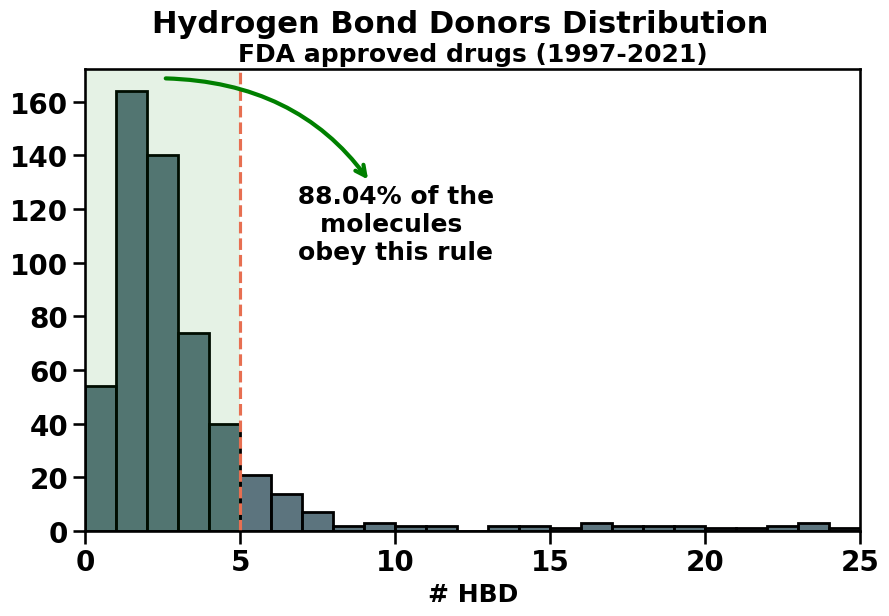

In [34]:
fig, ax = plt.subplots(figsize = (10,6))

dist_graph(
    df=drugs_db_route_merged, 
    col_name="n_hbd", 
    title="Hydrogen Bond Donors Distribution", 
    xlabel="# HBD", 
    binwidth=1, 
    threshold=5, 
    xlim=(0, 25), 
    ax=ax, 
    fig=fig
)


# annotating the information about how % obey the lipinski's rules
param = ((drugs_db_route_merged.n_hbd <= 5).sum())/drugs.shape[0]

ax.annotate(f' {param:.2%} of the \nmolecules \nobey this rule',
            xy=(0.1, 0.98), xycoords='axes fraction',
            xytext=(0.4, 0.75), textcoords='axes fraction',
            arrowprops={"arrowstyle":"<-", "color":color_palette["arrow"], "lw":3, "connectionstyle":"arc3,rad=0.3"},
            verticalalignment='top', fontsize=18, fontweight=1000,
            horizontalalignment="center")
# saving plot
fig.savefig("../imgs/lipinski/dist_hbd.png", dpi=300)

In [35]:
hbd_investigate = drugs_db_route_merged[drugs_db_route_merged.n_hbd >= 25]

print(f'SHAPE: {hbd_investigate.shape}')
(hbd_investigate[["active","SMILES", "DrugBank ID", "Drug Groups", "n_hbd"]])

SHAPE: (4, 16)


,active,SMILES,DrugBank ID,Drug Groups,n_hbd
98,bivalirudin,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CC(O)=O)NC(=O)CNC(=O)[C@H](CC(N)=O)NC(=O)CNC(=O)CNC(=O)CNC(=O)CNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=N)NC(=O)[C@@H]1CCCN1C(=O)[C@H](N)CC1=CC=CC=C1)C(=O)N1CCC[C@H]1C(=O)N[C@@H](CCC(O)=O)C(=O)N[C@@H](CCC(O)=O)C(=O)N[C@@H](CC1=CC=C(O)C=C1)C(=O)N[C@@H](CC(C)C)C(O)=O,DB00006,approved; investigational,28
164,ziconotide,[H][C@]12CSSC[C@]3([H])NC(=O)[C@H](CCCCN)NC(=O)[C@H](C)NC(=O)CNC(=O)[C@H](CCCCN)NC(=O)CNC(=O)[C@H](CCCCN)NC(=O)[C@@H](N)CSSC[C@]([H])(NC(=O)[C@]([H])(CSSC[C@H](NC(=O)[C@H](CCCCN)NC(=O)CNC(=O)[C@H](CO)NC(=O)[C@H](CCCNC(N)=N)NC1=O)C(N)=O)NC(=O)[C@H](CC(O)=O)NC(=O)[C@H](CC1=CC=C(O)C=C1)NC(=O)[C@H](CCSC)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCCNC(N)=N)NC(=O)[C@H](CO)NC3=O)C(=O)N[C@@]([H])([C@@H](C)O)C(=O)NCC(=O)N[C@@H](CO)C(=O)N2,DB06283,approved,42
167,pramlintide,[H]N[C@@H](CCCCN)C(=O)N[C@H]1CSSC[C@H](NC(=O)[C@@]([H])(NC(=O)[C@H](C)NC(=O)[C@@]([H])(NC(=O)[C@H](CC(N)=O)NC1=O)[C@@H](C)O)[C@@H](C)O)C(=O)N[C@@H](C)C(=O)N[C@@]([H])([C@@H](C)O)C(=O)N[C@@H](CCC(N)=O)C(=O)N[C@@H](CCCNC(N)=N)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](C)C(=O)N[C@@H](CC(N)=O)C(=O)N[C@@H](CC1=CC=CC=C1)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](C(C)C)C(=O)N[C@@H](CC1=CN=CN1)C(=O)N[C@@H](CO)C(=O)N[C@@H](CO)C(=O)N[C@@H](CC(N)=O)C(=O)N[C@@H](CC(N)=O)C(=O)N[C@@H](CC1=CC=CC=C1)C(=O)NCC(=O)N1CCC[C@H]1C(=O)N[C@@]([H])([C@@H](C)CC)C(=O)N[C@@H](CC(C)C)C(=O)N1CCC[C@H]1C(=O)N1CCC[C@H]1C(=O)N[C@@]([H])([C@@H](C)O)C(=O)N[C@@H](CC(N)=O)C(=O)N[C@@H](C(C)C)C(=O)NCC(=O)N[C@@H](CO)C(=O)N[C@@H](CC(N)=O)C(=O)N[C@@]([H])([C@@H](C)O)C(=O)N[C@@H](CC1=CC=C(O)C=C1)C(N)=O,DB01278,approved; investigational,56
398,semaglutide,CC[C@H](C)[C@H](NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CCCCNC(=O)COCCOCCNC(=O)COCCOCCNC(=O)CC[C@@H](NC(=O)CCCCCCCCCCCCCCCCC(O)=O)C(O)=O)NC(=O)[C@H](C)NC(=O)[C@H](C)NC(=O)[C@H](CCC(N)=O)NC(=O)CNC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC1=CC=C(O)C=C1)NC(=O)[C@H](CO)NC(=O)[C@H](CO)NC(=O)[C@@H](NC(=O)[C@H](CC(O)=O)NC(=O)[C@H](CO)NC(=O)[C@@H](NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@@H](NC(=O)CNC(=O)[C@H](CCC(O)=O)NC(=O)C(C)(C)NC(=O)[C@@H](N)CC1=CN=CN1)[C@@H](C)O)[C@@H](C)O)C(C)C)C(=O)N[C@@H](C)C(=O)N[C@@H](CC1=CNC2=C1C=CC=C2)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](C(C)C)C(=O)N[C@@H](CCCNC(N)=N)C(=O)NCC(=O)N[C@@H](CCCNC(N)=N)C(=O)NCC(O)=O,DB13928,approved; investigational,57


### 2.3) Number of Hydrogen Bond Acceptors

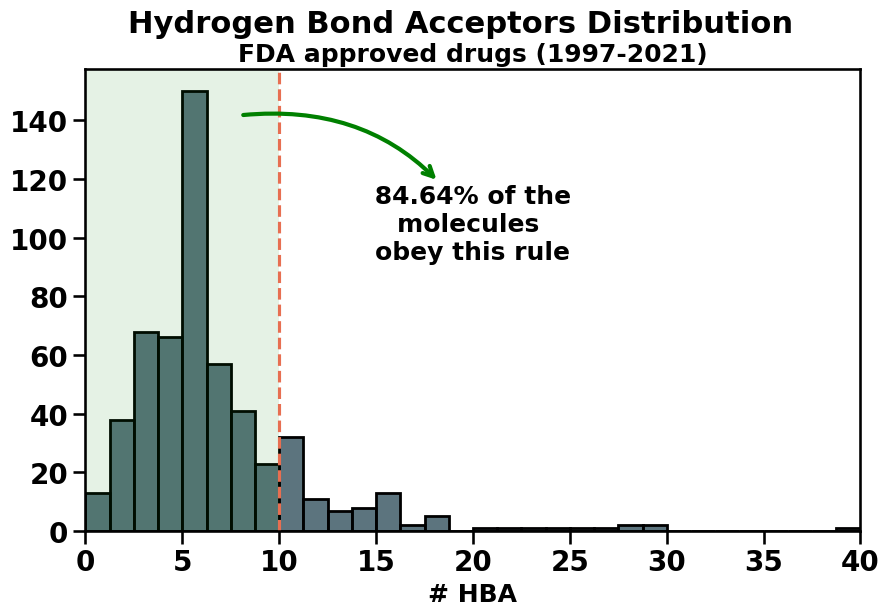

In [36]:
fig, ax = plt.subplots(figsize = (10,6))

dist_graph(
    df=drugs_db_route_merged, 
    col_name="n_hba", 
    title="Hydrogen Bond Acceptors Distribution", 
    xlabel="# HBA", 
    binwidth=1.25, 
    threshold=10, 
    xlim=(0, 40), 
    ax=ax, 
    fig=fig
)


# annotating the information about how % obey the lipinski's rules
param = ((drugs_db_route_merged.n_hba <= 10).sum())/drugs.shape[0]

ax.annotate(f' {param:.2%} of the \nmolecules \nobey this rule',
            xy=(0.2, 0.9), xycoords='axes fraction',
            xytext=(0.5, 0.75), textcoords='axes fraction',
            arrowprops={"arrowstyle":"<-", "color":color_palette["arrow"], "lw":3, "connectionstyle":"arc3,rad=0.3"},
            verticalalignment='top', fontsize=18, fontweight=1000,
            horizontalalignment="center")
# saving plot
fig.savefig("../imgs/lipinski/dist_hba.png", dpi=300)

In [37]:
n_hba_investigate = drugs_db_route_merged[drugs_db_route_merged.n_hba >= 40]

print(f'SHAPE: {n_hba_investigate.shape}')
(n_hba_investigate[["active","SMILES", "DrugBank ID", "Drug Groups", "n_hba", "route"]])

SHAPE: (4, 16)


,active,SMILES,DrugBank ID,Drug Groups,n_hba,route
164,ziconotide,[H][C@]12CSSC[C@]3([H])NC(=O)[C@H](CCCCN)NC(=O)[C@H](C)NC(=O)CNC(=O)[C@H](CCCCN)NC(=O)CNC(=O)[C@H](CCCCN)NC(=O)[C@@H](N)CSSC[C@]([H])(NC(=O)[C@]([H])(CSSC[C@H](NC(=O)[C@H](CCCCN)NC(=O)CNC(=O)[C@H](CO)NC(=O)[C@H](CCCNC(N)=N)NC1=O)C(N)=O)NC(=O)[C@H](CC(O)=O)NC(=O)[C@H](CC1=CC=C(O)C=C1)NC(=O)[C@H](CCSC)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCCNC(N)=N)NC(=O)[C@H](CO)NC3=O)C(=O)N[C@@]([H])([C@@H](C)O)C(=O)NCC(=O)N[C@@H](CO)C(=O)N2,DB06283,approved,45,intrathecal
167,pramlintide,[H]N[C@@H](CCCCN)C(=O)N[C@H]1CSSC[C@H](NC(=O)[C@@]([H])(NC(=O)[C@H](C)NC(=O)[C@@]([H])(NC(=O)[C@H](CC(N)=O)NC1=O)[C@@H](C)O)[C@@H](C)O)C(=O)N[C@@H](C)C(=O)N[C@@]([H])([C@@H](C)O)C(=O)N[C@@H](CCC(N)=O)C(=O)N[C@@H](CCCNC(N)=N)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](C)C(=O)N[C@@H](CC(N)=O)C(=O)N[C@@H](CC1=CC=CC=C1)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](C(C)C)C(=O)N[C@@H](CC1=CN=CN1)C(=O)N[C@@H](CO)C(=O)N[C@@H](CO)C(=O)N[C@@H](CC(N)=O)C(=O)N[C@@H](CC(N)=O)C(=O)N[C@@H](CC1=CC=CC=C1)C(=O)NCC(=O)N1CCC[C@H]1C(=O)N[C@@]([H])([C@@H](C)CC)C(=O)N[C@@H](CC(C)C)C(=O)N1CCC[C@H]1C(=O)N1CCC[C@H]1C(=O)N[C@@]([H])([C@@H](C)O)C(=O)N[C@@H](CC(N)=O)C(=O)N[C@@H](C(C)C)C(=O)NCC(=O)N[C@@H](CO)C(=O)N[C@@H](CC(N)=O)C(=O)N[C@@]([H])([C@@H](C)O)C(=O)N[C@@H](CC1=CC=C(O)C=C1)C(N)=O,DB01278,approved; investigational,59,subcutaneous
364,sugammadex,O[C@@H]1[C@@H](O)[C@@H]2O[C@H]3O[C@H](CSCCC(O)=O)[C@@H](O[C@H]4O[C@H](CSCCC(O)=O)[C@@H](O[C@H]5O[C@H](CSCCC(O)=O)[C@@H](O[C@H]6O[C@H](CSCCC(O)=O)[C@@H](O[C@H]7O[C@H](CSCCC(O)=O)[C@@H](O[C@H]8O[C@H](CSCCC(O)=O)[C@@H](O[C@H]9O[C@H](CSCCC(O)=O)[C@@H](O[C@H]1O[C@@H]2CSCCC(O)=O)[C@H](O)[C@H]9O)[C@H](O)[C@H]8O)[C@H](O)[C@H]7O)[C@H](O)[C@H]6O)[C@H](O)[C@H]5O)[C@H](O)[C@H]4O)[C@H](O)[C@H]3O,DB06206,approved,48,intravenous
398,semaglutide,CC[C@H](C)[C@H](NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CCCCNC(=O)COCCOCCNC(=O)COCCOCCNC(=O)CC[C@@H](NC(=O)CCCCCCCCCCCCCCCCC(O)=O)C(O)=O)NC(=O)[C@H](C)NC(=O)[C@H](C)NC(=O)[C@H](CCC(N)=O)NC(=O)CNC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC1=CC=C(O)C=C1)NC(=O)[C@H](CO)NC(=O)[C@H](CO)NC(=O)[C@@H](NC(=O)[C@H](CC(O)=O)NC(=O)[C@H](CO)NC(=O)[C@@H](NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@@H](NC(=O)CNC(=O)[C@H](CCC(O)=O)NC(=O)C(C)(C)NC(=O)[C@@H](N)CC1=CN=CN1)[C@@H](C)O)[C@@H](C)O)C(C)C)C(=O)N[C@@H](C)C(=O)N[C@@H](CC1=CNC2=C1C=CC=C2)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](C(C)C)C(=O)N[C@@H](CCCNC(N)=N)C(=O)NCC(=O)N[C@@H](CCCNC(N)=N)C(=O)NCC(O)=O,DB13928,approved; investigational,56,subcutaneous oral


### 2.4) Calculated LogP Distribution

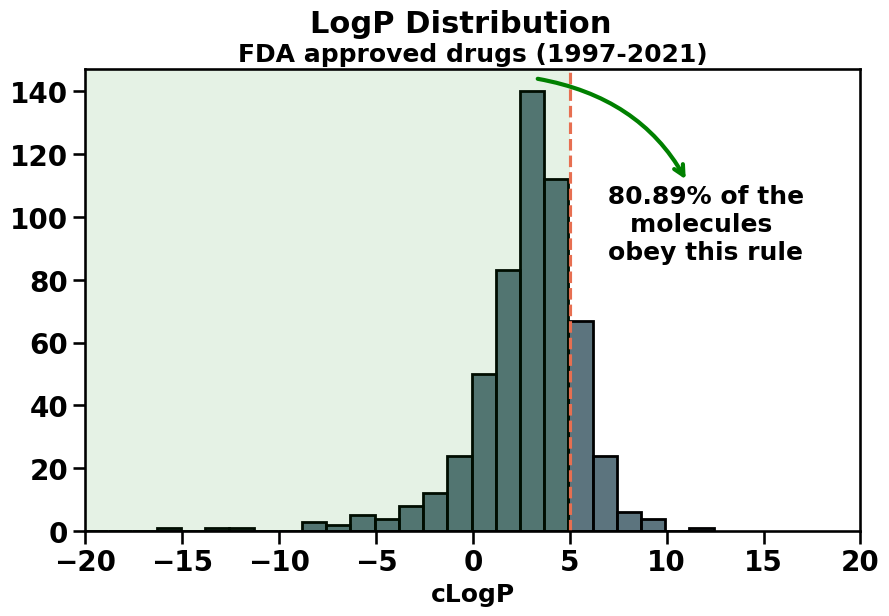

In [38]:
fig, ax = plt.subplots(figsize = (10,6))

dist_graph(
    df=drugs_db_route_merged, 
    col_name="logp", 
    title="LogP Distribution", 
    xlabel="cLogP", 
    binwidth=1.25, 
    threshold=5, 
    xlim=(-20, 20), 
    ax=ax, 
    fig=fig
)


# annotating the information about how % obey the lipinski's rules
param = ((drugs_db_route_merged.logp <= 5).sum())/drugs.shape[0]

ax.annotate(f' {param:.2%} of the \nmolecules \nobey this rule',
            xy=(0.58, 0.98), xycoords='axes fraction',
            xytext=(0.8, 0.75), textcoords='axes fraction',
            arrowprops={"arrowstyle":"<-", "color":color_palette["arrow"], "lw":3, "connectionstyle":"arc3,rad=0.3"},
            verticalalignment='top', fontsize=18, fontweight=1000,
            horizontalalignment="center")
# saving plot
fig.savefig("../imgs/lipinski/dist_logp.png", dpi=300)

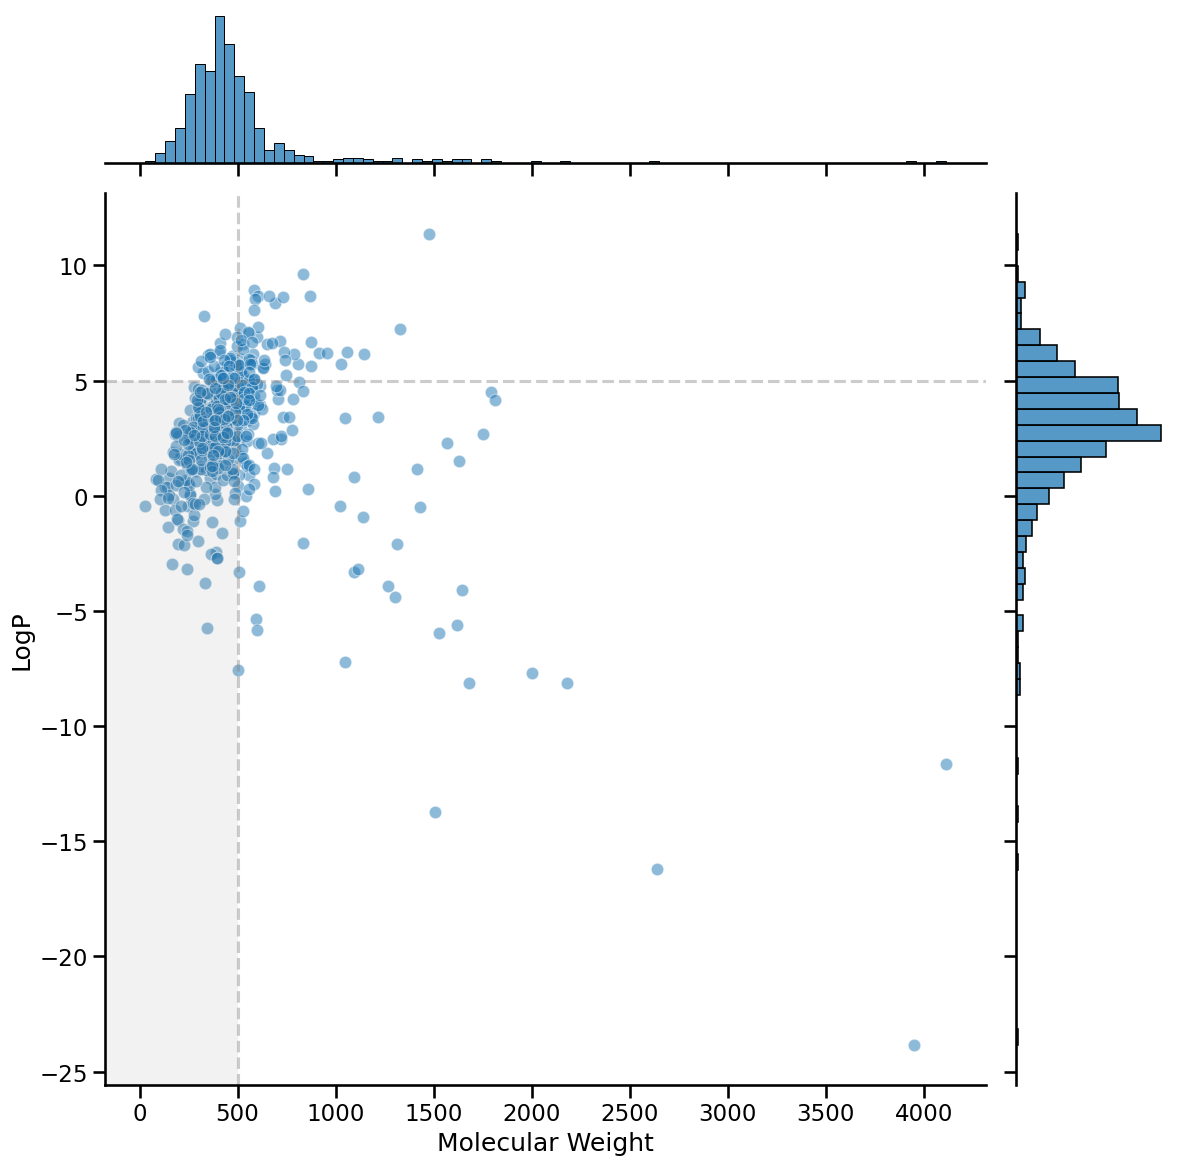

In [39]:
#create graph
joint_plot = sns.jointplot(y = 'logp', x = "mw", data = drugs_db_route_merged, height = 12, alpha=0.5)

# creating lines
joint_plot.ax_joint.axvline(x=500, linestyle='--', color = 'gray', alpha=0.4)
joint_plot.ax_joint.axhline(y=5, linestyle='--', color = 'gray', alpha=0.4)


# adding a shaded region
joint_plot.ax_joint.add_patch(Rectangle((-1000, -40),
                        1500, 45,
                        fc ='gray', 
                        ec ='none',
                        lw = 10, alpha = .1))

# changing x and y label
joint_plot.ax_joint.set_xlabel('Molecular Weight')
joint_plot.ax_joint.set_ylabel('LogP')

#saving plot
joint_plot.savefig("../imgs/lipinski/jointplot_logp_mw.png", dpi=300)

plt.show()

### 2.5) Distribution of the number of followed rules

We take a first look of the percentage of FDA approved drugs that followed all the Lipinski's rule of five:

In [40]:
# We create a boolean for obeying all the lipinski rules
lipinski = (drugs_db_route_merged.mw <= 500) & (drugs_db_route_merged.n_hbd <= 5) & (drugs_db_route_merged.n_hba <= 10) & (drugs_db_route_merged.logp <= 5)

# Printing the percentage
print(f"Percentage of FDA approved drugs that followed all of Lipinki's rule of five: "
      f"{drugs_db_route_merged[lipinski].shape[0] / drugs_db_route_merged.shape[0] * 100:.2f}%")

Percentage of FDA approved drugs that followed all of Lipinki's rule of five: 59.93%


Creating a column for each rule, in order to take a more deep look into each of 4 rules.

In [41]:
# Creating a column for each rule of the lipinski's rule of five
drugs_db_route_merged["lipinski_mw"] = drugs_db_route_merged.mw <= 500
drugs_db_route_merged["lipinski_hbd"] = drugs_db_route_merged.n_hbd <= 5
drugs_db_route_merged["lipinski_hba"] = drugs_db_route_merged.n_hba <= 10
drugs_db_route_merged["lipinski_logp"] = drugs_db_route_merged.logp <= 5

# How many rules were followed by each structure?
drugs_db_route_merged["n_follow_rules"] = drugs_db_route_merged.iloc[:,-4:].sum(axis = 1)

In [42]:
# Doing the same thing, for the dataset with only oral drugs
drugs_oral["lipinski_mw"] = drugs_oral.mw <= 500
drugs_oral["lipinski_hbd"] = drugs_oral.n_hbd <= 5
drugs_oral["lipinski_hba"] = drugs_oral.n_hba <= 10
drugs_oral["lipinski_logp"] = drugs_oral.logp <= 5

# How many rules were followed by each structure?
drugs_oral["n_follow_rules"] = drugs_oral.iloc[:,-4:].sum(axis = 1)

Then, we make a plot containing this information:
### 2.5.1) Countplot of the number of rules followed by the structures in the period

In [43]:
def countplot(df, df_oral, x, title, ylim, file_name, ax):
    COLOR_1 = color_palette["countplot_bar1"]
    COLOR_2 = color_palette["countplot_bar2"]

    # counting bins
    height_all = np.unique(df[x], return_counts=True)[1]
    height_oral = np.unique(df_oral[x], return_counts=True)[1]

    # creating x positions
    x_pos_all = []
    x_pos_oral = []
    x_ticks = []
    for i in range(len(height_all)):
        x_pos_all.append(i+0.17)
        x_pos_oral.append(i-0.17)
        x_ticks.append(i)


    # all drugs plot
    ax.bar(
        x=x_pos_all, 
        height=height_all, 
        color=COLOR_1, 
        label="All approved drugs", 
        width=0.3,
        linewidth=2,
        edgecolor="black"
    )

    # oral drugs plot
    ax.bar(
        x=x_pos_oral, 
        height=height_oral, 
        color=COLOR_2, 
        label="Only oral drugs", 
        width=-0.3,
        linewidth=2,
        edgecolor="black"
    )

    # Count of each bin
    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{}'.format(int(y)), (x.mean(), y), 
                ha='center', va='bottom', fontsize = 29, fontweight=1000) # set the alignment of the text

    # settings
    fig.suptitle(title, fontsize = 32, fontweight=1000)

    ax.set_xlabel("Number of rules followed", fontsize=29, fontweight=1000)
    ax.set_ylabel("")

    ax.set_ylim((0, ylim))

    ax.set_xticks(x_ticks)
    ax.set_yticks([i for i in range(0, ylim, 100)])

    plt.setp(ax.get_xticklabels(), fontsize=29, fontweight=627)
    plt.setp(ax.get_yticklabels(), fontsize=29, fontweight=624)

    font = matplotlib.font_manager.FontProperties(family="Arial", weight=1000, size=23)
    ax.legend(loc='upper left', prop=font)

    #saving plot
    fig.savefig(f"../imgs/{file_name}.png", dpi=300)

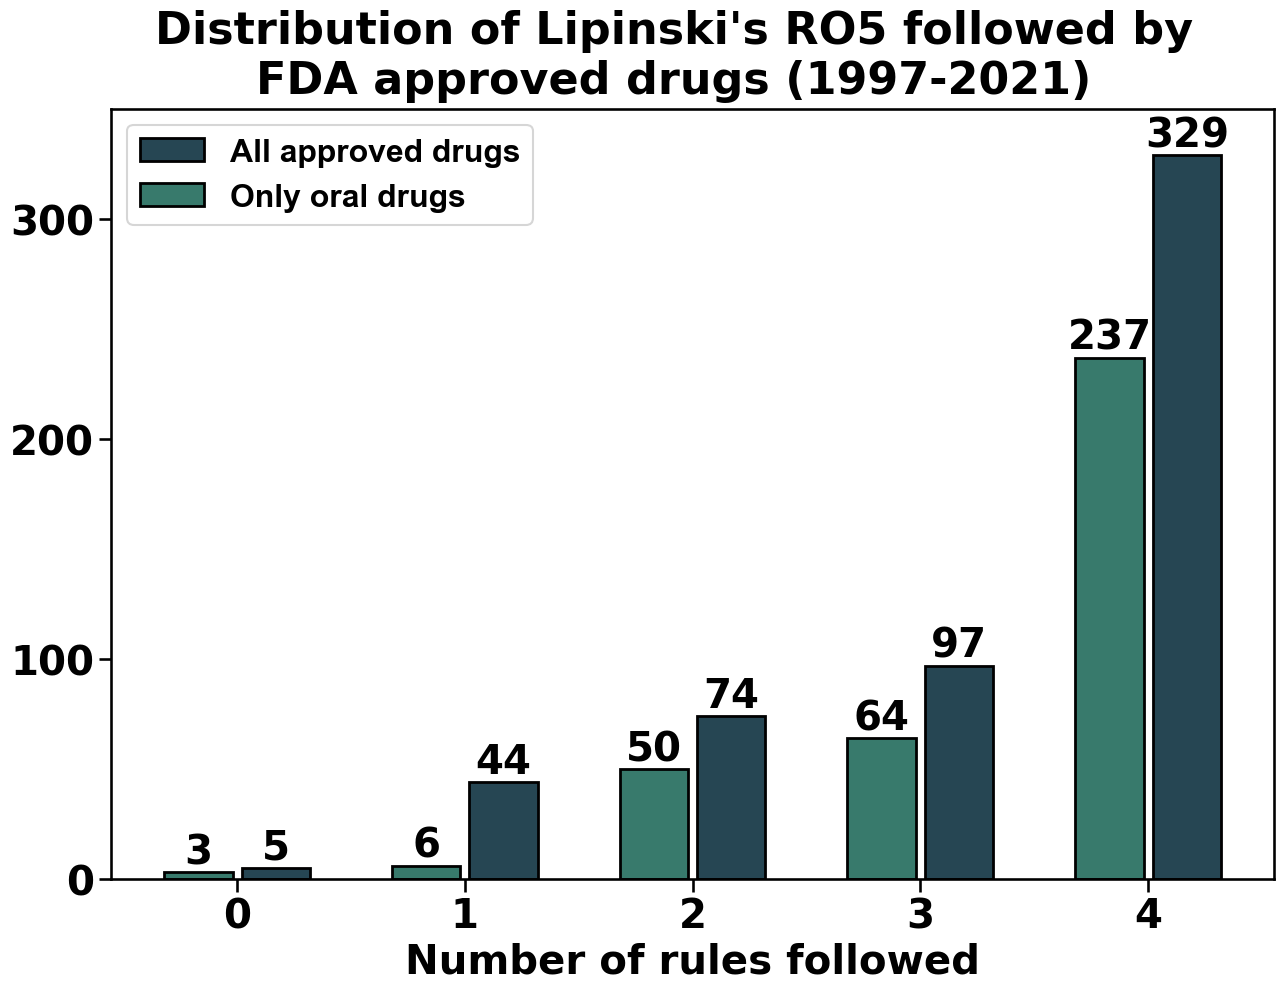

In [44]:
fig, ax = plt.subplots(figsize = (15,10))
countplot(
    df=drugs_db_route_merged, 
    df_oral=drugs_oral, 
    x="n_follow_rules",
    title="Distribution of Lipinski's RO5 followed by\nFDA approved drugs (1997-2021)",
    ylim=350,
    file_name="lipinski/countplot_n_follow_rules",
    ax=ax
)


In [45]:
# Printing the percentage
print(f"Percentage of FDA approved drugs that followed all of Lipinki's rule of five: "
      f"{drugs_db_route_merged[lipinski].shape[0] / drugs_db_route_merged.shape[0] * 100:.2f}%")

Percentage of FDA approved drugs that followed all of Lipinki's rule of five: 59.93%


In [46]:
# Printing the percentage
print(f"Percentage of FDA approved drugs that followed all of Lipinki's rule of five: "
      f"{drugs_db_route_merged[lipinski].shape[0] / drugs_db_route_merged.shape[0] * 100:.2f}%")

Percentage of FDA approved drugs that followed all of Lipinki's rule of five: 59.93%


In [47]:
print(f"{237/361*100:.2f}% of FDA approved drugs with oral admnistration follow all 4 lipinski's rule of 5")

65.65% of FDA approved drugs with oral admnistration follow all 4 lipinski's rule of 5


### Saving the structures that do not follow any of the rules

In [48]:
IPythonConsole.drawOptions.useBWAtomPalette()
none_lipinski = list(drugs_db_route_merged[drugs_db_route_merged.n_follow_rules == 0]["SMILES"])

ms = [Chem.MolFromSmiles(x) for x in none_lipinski]

img = Draw.MolsToGridImage(ms, subImgSize = (1250,770), molsPerRow = 2, returnPNG=False, 
                           legends = list(drugs_db_route_merged[drugs_db_route_merged.n_follow_rules == 0]["active"]))
img.save("../imgs/lipinski/molecules_follow_no_rules.png")

,active_ingredient_moiety,nda_bla,approval_year,active,DrugBank ID,Drug Groups,SMILES,Name,Drug Type,ROMol,...,mw,n_hba,n_hbd,logp,route,lipinski_mw,lipinski_hbd,lipinski_hba,lipinski_logp,n_follow_rules
42,rifapentine,NDA,1998,rifapentine,DB01201,approved; investigational,CO[C@H]1\C=C\O[C@@]2(C)OC3=C(C2=O)C2=C(C(O)=C3C)C(O)=C(NC(=O)\C(C)=C/C=C/[C@H](C)[C@H](O)[C@@H](C)[C@@H](O)[C@@H](C)[C@H](OC(C)=O)[C@@H]1C)C(\C=N\N1CCN(CC1)C1CCCC1)=C2O,Rifapentine,SmallMoleculeDrug,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",...,876.452073,15,6,5.64822,oral,False,False,False,False,0
268,fidaxomicin,NDA,2011,fidaxomicin,DB08874,approved,[H][C@@]1(O[C@@H]2[C@@H](CC)\C=C(C)\[C@@H](O)C\C=C\C=C(CO[C@@H]3O[C@H](C)[C@@H](OC(=O)C4=C(CC)C(Cl)=C(O)C(Cl)=C4O)[C@H](O)[C@@H]3OC)\C(=O)O[C@@H](C\C=C(/C)\C=C2/C)[C@@H](C)O)OC(C)(C)[C@@H](OC(=O)C(C)C)[C@H](O)[C@@H]1O,Fidaxomicin,SmallMoleculeDrug,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",...,1056.425221,18,7,6.23440,oral,False,False,False,False,0
454,tenapanor,NDA,2019,tenapanor,DB11761,approved; investigational,CN1C[C@@H](C2=CC(=CC=C2)S(=O)(=O)NCCOCCOCCNC(=O)NCCCCNC(=O)NCCOCCOCCNS(=O)(=O)C2=CC(=CC=C2)[C@@H]2CN(C)CC3=C2C=C(Cl)C=C3Cl)C2=C(C1)C(Cl)=CC(Cl)=C2,Tenapanor,SmallMoleculeDrug,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",...,1142.309743,12,6,6.15660,oral,False,False,False,False,0
523,pafolacianine,NDA,2021,pafolacianine,DB15413,approved; investigational,CC1(C)\C(=C/C=C2\CCCC(\C=C\C3=[N+](CCCCS(O)(=O)=O)C4=C(C=C(C=C4)S([O-])(=O)=O)C3(C)C)=C2OC2=CC=C(C[C@H](NC(=O)C3=CC=C(NCC4=CN=C5N=C(N)NC(=O)C5=N4)C=C3)C(O)=O)C=C2)N(CCCCS(O)(=O)=O)C2=C1C=C(C=C2)S(O)(=O)=O,Pafolacianine,SmallMoleculeDrug,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",...,1326.361052,18,9,7.22000,intravenous,False,False,False,False,0
539,trypan blue,NDA,2004,trypan blue,DB09158,approved,CC1=CC(=CC=C1\N=N\C1=C(C=C2C=C(C=C(N)C2=C1O)S(O)(=O)=O)S(O)(=O)=O)C1=CC(C)=C(C=C1)\N=N\C1=C(O)C2=C(N)C=C(C=C2C=C1S(O)(=O)=O)S(O)(=O)=O,Trypan blue free acid,SmallMoleculeDrug,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",...,872.054634,16,8,6.67004,intravenous,False,False,False,False,0

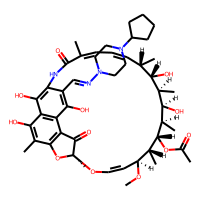
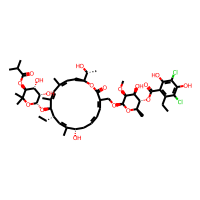
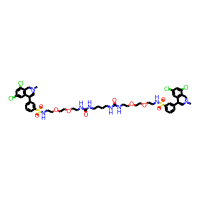
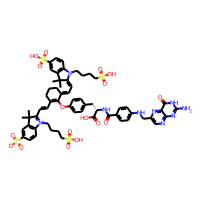
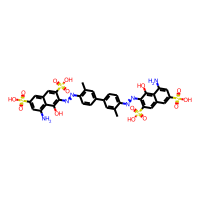

In [49]:
drugs_db_route_merged[drugs_db_route_merged.n_follow_rules == 0]

### 2.5.2) Countplot of the number of rules followed by the structures per year

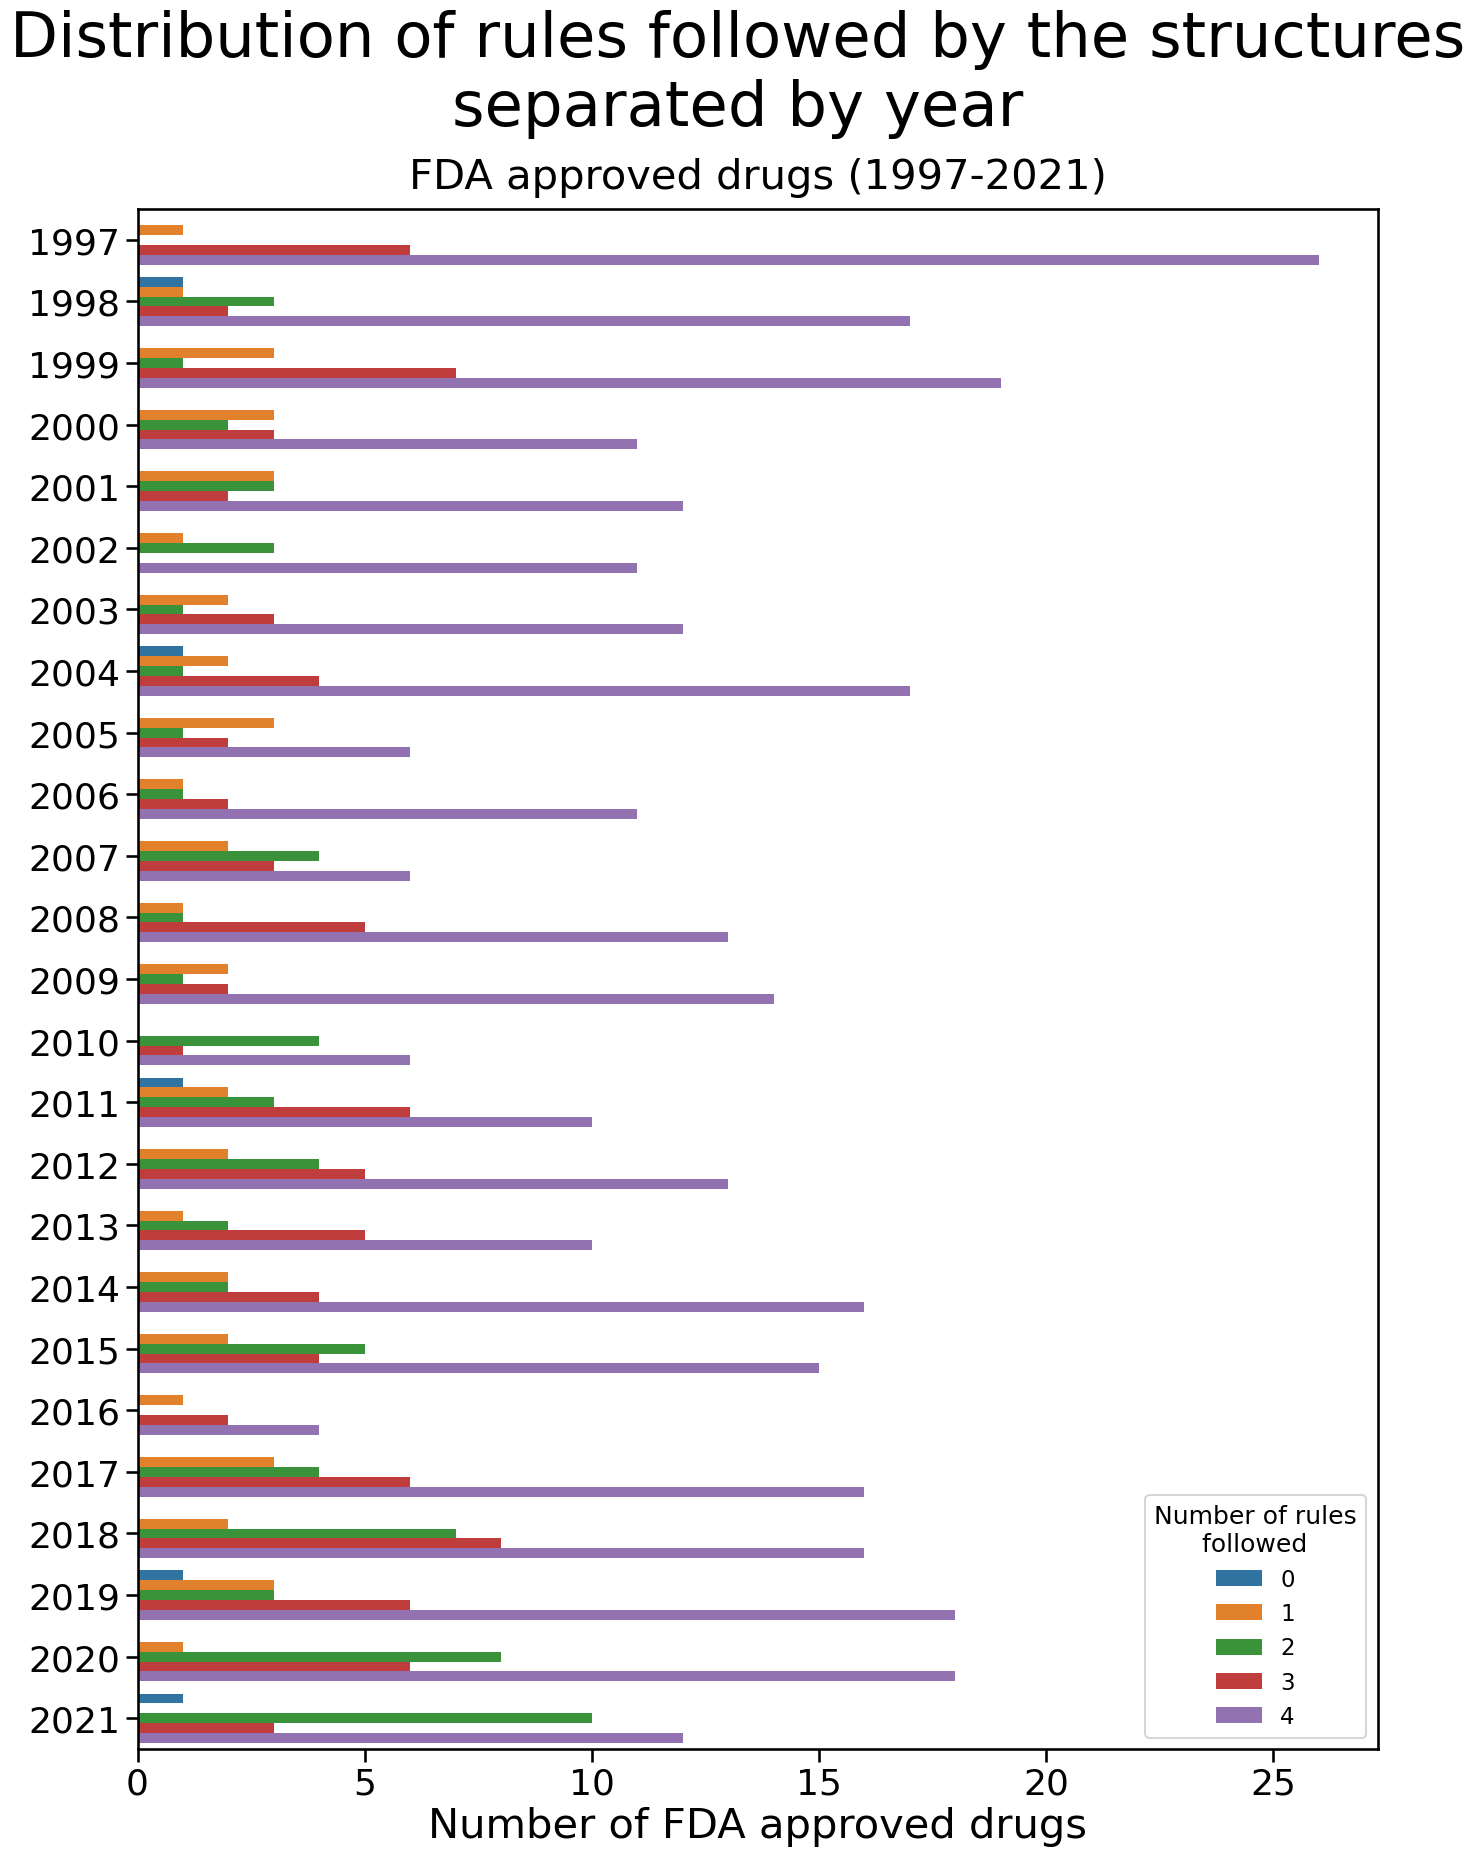

In [50]:
# Setting the plot sizes
fig, ax = plt.subplots(figsize = (16,20))

# The plot
lipinski_plot = sns.countplot(data = drugs_db_route_merged, y = "approval_year", hue = 'n_follow_rules')

lipinski_plot.set_title("FDA approved drugs (1997-2021)", pad = 15, fontsize = 30)
lipinski_plot.set_xlabel("Number of FDA approved drugs", size = 30)
lipinski_plot.set_ylabel("", size = 10)
#Increasing y-tick label size
lipinski_plot.tick_params(labelsize = 26)
# Title superior to the title plot
fig.suptitle("Distribution of rules followed by the structures\nseparated by year", fontsize = 45)

# Legend title
ax.legend(title='Number of rules\n      followed')

#saving plot
fig.savefig("../imgs/lipinski/countplot_n_follow_rules_per_year_vertical.png", dpi=300)

### 2.6) Analysing only the Drugs with oral route of admnistration

Lipinski's rule of 5 was made with the thought of filtering molecules for possible oral admnistration.

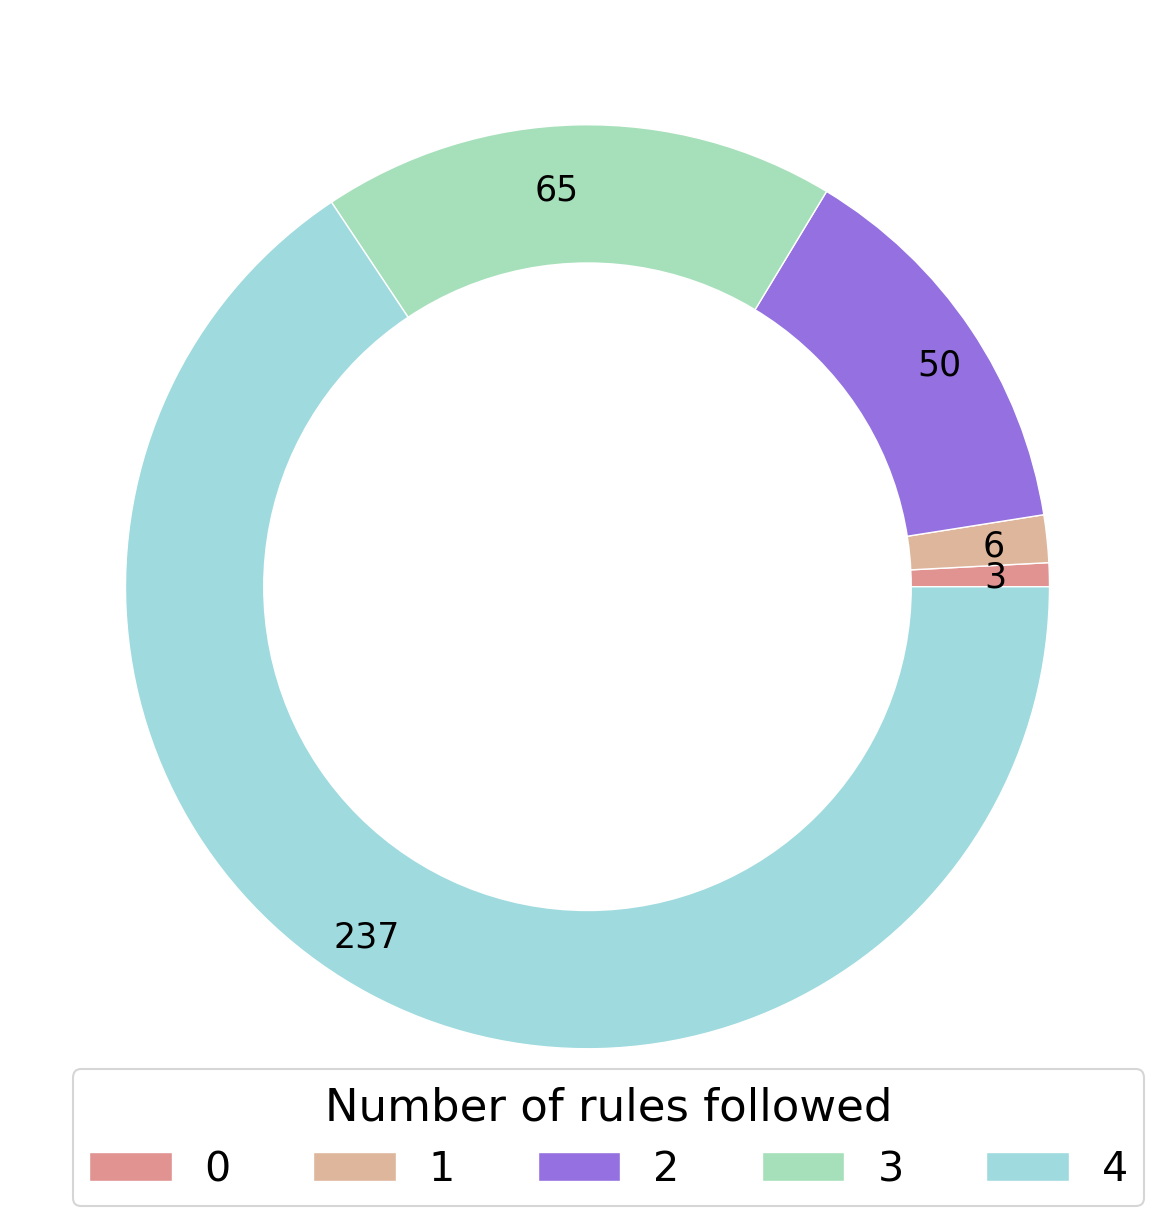

In [51]:
fig, ax = plt.subplots(figsize = (17,15))
sns.set_context("talk", font_scale = 1.8)


names = [0, 1, 2, 3, 4]
num_fol_rule = [3, 6, 50, 65, 237]

plt.pie(num_fol_rule, labels=num_fol_rule, wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white' }, labeldistance = 0.86,
       colors = ["#E09391", "#DEB69B", "#9470E0", "#A6E0BA", "#9EDADE"], textprops={'fontsize': 25})

# add a circle at the center to transform it in a donut chart
my_circle=plt.Circle((0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
# legend
plt.legend(title='Number of rules followed', ncol =  5, bbox_to_anchor=(1,0.1), labels = names)

#saving plot
fig.savefig("../imgs/lipinski/donut_n_follow_rules_oral.png", dpi=300)

These are the oral drugs that doesn't follow any lipinski rules:

In [52]:
drugs_oral[drugs_oral["n_follow_rules"] == 0].drop(["ROMol", "Mol_Clean"], axis = 1)

,active_ingredient_moiety,nda_bla,approval_year,active,DrugBank ID,Drug Groups,SMILES,Name,Drug Type,mw,n_hba,n_hbd,logp,route,lipinski_mw,lipinski_hbd,lipinski_hba,lipinski_logp,n_follow_rules
42,rifapentine,NDA,1998,rifapentine,DB01201,approved; investigational,CO[C@H]1\C=C\O[C@@]2(C)OC3=C(C2=O)C2=C(C(O)=C3C)C(O)=C(NC(=O)\C(C)=C/C=C/[C@H](C)[C@H](O)[C@@H](C)[C@@H](O)[C@@H](C)[C@H](OC(C)=O)[C@@H]1C)C(\C=N\N1CCN(CC1)C1CCCC1)=C2O,Rifapentine,SmallMoleculeDrug,876.452073,15,6,5.64822,oral,False,False,False,False,0
268,fidaxomicin,NDA,2011,fidaxomicin,DB08874,approved,[H][C@@]1(O[C@@H]2[C@@H](CC)\C=C(C)\[C@@H](O)C\C=C\C=C(CO[C@@H]3O[C@H](C)[C@@H](OC(=O)C4=C(CC)C(Cl)=C(O)C(Cl)=C4O)[C@H](O)[C@@H]3OC)\C(=O)O[C@@H](C\C=C(/C)\C=C2/C)[C@@H](C)O)OC(C)(C)[C@@H](OC(=O)C(C)C)[C@H](O)[C@@H]1O,Fidaxomicin,SmallMoleculeDrug,1056.425221,18,7,6.23440,oral,False,False,False,False,0
454,tenapanor,NDA,2019,tenapanor,DB11761,approved; investigational,CN1C[C@@H](C2=CC(=CC=C2)S(=O)(=O)NCCOCCOCCNC(=O)NCCCCNC(=O)NCCOCCOCCNS(=O)(=O)C2=CC(=CC=C2)[C@@H]2CN(C)CC3=C2C=C(Cl)C=C3Cl)C2=C(C1)C(Cl)=CC(Cl)=C2,Tenapanor,SmallMoleculeDrug,1142.309743,12,6,6.15660,oral,False,False,False,False,0


In comparison we have all the drugs that follow 0 Lipinski's rules (all the dosage forms):

In [53]:
drugs_db_route_merged[drugs_db_route_merged.n_follow_rules == 0].drop(["ROMol", "Mol_Clean"], axis = 1)

,active_ingredient_moiety,nda_bla,approval_year,active,DrugBank ID,Drug Groups,SMILES,Name,Drug Type,mw,n_hba,n_hbd,logp,route,lipinski_mw,lipinski_hbd,lipinski_hba,lipinski_logp,n_follow_rules
42,rifapentine,NDA,1998,rifapentine,DB01201,approved; investigational,CO[C@H]1\C=C\O[C@@]2(C)OC3=C(C2=O)C2=C(C(O)=C3C)C(O)=C(NC(=O)\C(C)=C/C=C/[C@H](C)[C@H](O)[C@@H](C)[C@@H](O)[C@@H](C)[C@H](OC(C)=O)[C@@H]1C)C(\C=N\N1CCN(CC1)C1CCCC1)=C2O,Rifapentine,SmallMoleculeDrug,876.452073,15,6,5.64822,oral,False,False,False,False,0
268,fidaxomicin,NDA,2011,fidaxomicin,DB08874,approved,[H][C@@]1(O[C@@H]2[C@@H](CC)\C=C(C)\[C@@H](O)C\C=C\C=C(CO[C@@H]3O[C@H](C)[C@@H](OC(=O)C4=C(CC)C(Cl)=C(O)C(Cl)=C4O)[C@H](O)[C@@H]3OC)\C(=O)O[C@@H](C\C=C(/C)\C=C2/C)[C@@H](C)O)OC(C)(C)[C@@H](OC(=O)C(C)C)[C@H](O)[C@@H]1O,Fidaxomicin,SmallMoleculeDrug,1056.425221,18,7,6.23440,oral,False,False,False,False,0
454,tenapanor,NDA,2019,tenapanor,DB11761,approved; investigational,CN1C[C@@H](C2=CC(=CC=C2)S(=O)(=O)NCCOCCOCCNC(=O)NCCCCNC(=O)NCCOCCOCCNS(=O)(=O)C2=CC(=CC=C2)[C@@H]2CN(C)CC3=C2C=C(Cl)C=C3Cl)C2=C(C1)C(Cl)=CC(Cl)=C2,Tenapanor,SmallMoleculeDrug,1142.309743,12,6,6.15660,oral,False,False,False,False,0
523,pafolacianine,NDA,2021,pafolacianine,DB15413,approved; investigational,CC1(C)\C(=C/C=C2\CCCC(\C=C\C3=[N+](CCCCS(O)(=O)=O)C4=C(C=C(C=C4)S([O-])(=O)=O)C3(C)C)=C2OC2=CC=C(C[C@H](NC(=O)C3=CC=C(NCC4=CN=C5N=C(N)NC(=O)C5=N4)C=C3)C(O)=O)C=C2)N(CCCCS(O)(=O)=O)C2=C1C=C(C=C2)S(O)(=O)=O,Pafolacianine,SmallMoleculeDrug,1326.361052,18,9,7.22000,intravenous,False,False,False,False,0
539,trypan blue,NDA,2004,trypan blue,DB09158,approved,CC1=CC(=CC=C1\N=N\C1=C(C=C2C=C(C=C(N)C2=C1O)S(O)(=O)=O)S(O)(=O)=O)C1=CC(C)=C(C=C1)\N=N\C1=C(O)C2=C(N)C=C(C=C2C=C1S(O)(=O)=O)S(O)(=O)=O,Trypan blue free acid,SmallMoleculeDrug,872.054634,16,8,6.67004,intravenous,False,False,False,False,0


These are the oral drugs that follow only 1 lipinski rule:

In [54]:
drugs_oral[drugs_oral["n_follow_rules"] == 1].drop(["ROMol", "Mol_Clean"], axis = 1)

,active_ingredient_moiety,nda_bla,approval_year,active,DrugBank ID,Drug Groups,SMILES,Name,Drug Type,mw,n_hba,n_hbd,logp,route,lipinski_mw,lipinski_hbd,lipinski_hba,lipinski_logp,n_follow_rules
155,rifaximin,NDA,2004,rifaximin,DB01220,approved; investigational,CO[C@H]1\C=C\O[C@@]2(C)OC3=C(C)C(O)=C4C(O)=C(NC(=O)\C(C)=C/C=C/[C@H](C)[C@H](O)[C@@H](C)[C@@H](O)[C@@H](C)[C@H](OC(C)=O)[C@@H]1C)C1=C(N=C5C=C(C)C=CN15)C4=C3C2=O,Rifaximin,SmallMoleculeDrug,785.352359,13,5,6.15784,oral,False,True,False,False,1
229,everolimus,NDA,2009,everolimus,DB01590,approved,[H][C@@]1(C[C@@H](C)[C@]2([H])CC(=O)[C@H](C)\C=C(C)\[C@@H](O)[C@@H](OC)C(=O)[C@H](C)C[C@H](C)\C=C\C=C\C=C(C)\[C@H](C[C@]3([H])CC[C@@H](C)[C@@](O)(O3)C(=O)C(=O)N3CCCC[C@@]3([H])C(=O)O2)OC)CC[C@@H](OCCO)[C@@H](C1)OC,Everolimus,SmallMoleculeDrug,957.581356,14,3,6.19720,oral,False,True,False,False,1
289,linaclotide,NDA,2012,linaclotide,DB08890,approved,[H][C@]1(CSSC[C@]2([H])NC(=O)[C@H](CC3=CC=C(O)C=C3)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@@H]3CSSC[C@H](NC(=O)[C@H](C)NC(=O)[C@@H]4CCCN4C(=O)[C@H](CC(N)=O)NC(=O)[C@H](CSSC[C@H](N)C(=O)N3)NC2=O)C(=O)N[C@@]([H])([C@@H](C)O)C(=O)NCC(=O)N1)C(=O)N[C@@H](CC1=CC=C(O)C=C1)C(O)=O,Linaclotide,SmallMoleculeDrug,1525.389921,26,19,-5.93920,oral,False,False,False,True,1
368,venetoclax,NDA,2016,venetoclax,DB11581,approved; investigational,CC1(C)CCC(CN2CCN(CC2)C2=CC=C(C(=O)NS(=O)(=O)C3=CC=C(NCC4CCOCC4)C(=C3)[N+]([O-])=O)C(OC3=CN=C4NC=CC4=C3)=C2)=C(C1)C1=CC=C(Cl)C=C1,Venetoclax,SmallMoleculeDrug,867.318096,11,3,8.65990,oral,False,True,False,False,1
374,plecanatide,NDA,2017,plecanatide,DB13170,approved; investigational,[H][C@@]12CSSC[C@H](NC(=O)CNC(=O)[C@@]([H])(NC(=O)[C@]([H])(CSSC[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC(O)=O)NC(=O)[C@@H](N)CC(N)=O)C(=O)N[C@@H](CCC(O)=O)C(=O)N[C@@H](CC(C)C)C(=O)N1)NC(=O)[C@H](C)NC(=O)[C@@H](NC(=O)[C@H](CC(N)=O)NC(=O)[C@@H](NC2=O)C(C)C)C(C)C)[C@@H](C)O)C(=O)N[C@@H](CC(C)C)C(O)=O,Plecanatide,SmallMoleculeDrug,1680.625199,27,23,-8.14830,oral,False,False,False,True,1
430,rifamycin,NDA,2018,rifamycin,DB11753,approved; investigational,CO[C@H]1\C=C\O[C@@]2(C)OC3=C(C)C(O)=C4C(O)=C(NC(=O)\C(C)=C/C=C/[C@H](C)[C@H](O)[C@@H](C)[C@@H](O)[C@@H](C)[C@H](OC(C)=O)[C@@H]1C)C=C(O)C4=C3C2=O,Rifamycin,SmallMoleculeDrug,697.309826,12,6,4.75412,oral,False,False,False,True,1


These are the drugs that follow only 1 lipinski rule:

In [55]:
drugs_db_route_merged[drugs_db_route_merged["n_follow_rules"] == 1].drop(["ROMol", "Mol_Clean"], axis = 1)

,active_ingredient_moiety,nda_bla,approval_year,active,DrugBank ID,Drug Groups,SMILES,Name,Drug Type,mw,n_hba,n_hbd,logp,route,lipinski_mw,lipinski_hbd,lipinski_hba,lipinski_logp,n_follow_rules
23,mangafodipir trisodium,NDA,1997,mangafodipir,DB06796,approved; investigational; withdrawn,[Mn++].CC1=C(O)C(CN(CCN(CC([O-])=O)CC2=CC(COP(O)(O)=O)=NC(C)=C2O)CC([O-])=O)=CC(COP(O)(O)=O)=N1,Mangafodipir,SmallMoleculeDrug,693.075973,12,8,0.19414,injection,False,False,False,True,1
64,ganirelix acetate,NDA,1999,ganirelix,DB06785,approved,CCNC(NCC)=NCCCC[C@@H](NC(=O)[C@H](CC1=CC=C(O)C=C1)NC(=O)[C@H](CO)NC(=O)[C@@H](CC1=CC=CN=C1)NC(=O)[C@@H](CC1=CC=C(Cl)C=C1)NC(=O)[C@@H](CC1=CC2=CC=CC=C2C=C1)NC(C)=O)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CCCCN=C(NCC)NCC)C(=O)N1CCC[C@H]1C(=O)N[C@H](C)C(N)=O,Ganirelix,SmallMoleculeDrug,1568.842303,16,16,2.27270,injection,False,False,False,True,1
69,epirubicin hydrochloride,NDA,1999,epirubicin,DB00445,approved,COC1=CC=CC2=C1C(=O)C1=C(O)C3=C(C[C@](O)(C[C@@H]3O[C@H]3C[C@H](N)[C@@H](O)[C@H](C)O3)C(=O)CO)C(O)=C1C2=O,Epirubicin,SmallMoleculeDrug,543.174061,12,6,0.00130,injection,False,False,False,True,1
70,sirolimus,NDA,1999,sirolimus,DB00877,approved; investigational,[H][C@@]1(C[C@@H](C)[C@]2([H])CC(=O)[C@H](C)\C=C(C)\[C@@H](O)[C@@H](OC)C(=O)[C@H](C)C[C@H](C)\C=C\C=C\C=C(C)\[C@H](C[C@]3([H])CC[C@@H](C)[C@@](O)(O3)C(=O)C(=O)N3CCCC[C@@]3([H])C(=O)O2)OC)CC[C@@H](O)[C@@H](C1)OC,Sirolimus,SmallMoleculeDrug,913.555142,13,3,6.18060,oral intravenous,False,True,False,False,1
95,cetrorelix acetate,NDA,2000,cetrorelix,DB00050,approved; investigational,CC(C)C[C@H](NC(=O)[C@@H](CCCNC(N)=O)NC(=O)[C@H](CC1=CC=C(O)C=C1)NC(=O)[C@H](CO)NC(=O)[C@@H](CC1=CN=CC=C1)NC(=O)[C@@H](CC1=CC=C(Cl)C=C1)NC(=O)[C@@H](CC1=CC2=CC=CC=C2C=C1)NC(C)=O)C(=O)N[C@@H](CCCNC(N)=N)C(=O)N1CCC[C@H]1C(=O)N[C@H](C)C(N)=O,Cetrorelix,SmallMoleculeDrug,1429.669818,16,17,-0.50613,injection,False,False,False,True,1
98,bivalirudin,NDA,2000,bivalirudin,DB00006,approved; investigational,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CC(O)=O)NC(=O)CNC(=O)[C@H](CC(N)=O)NC(=O)CNC(=O)CNC(=O)CNC(=O)CNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=N)NC(=O)[C@@H]1CCCN1C(=O)[C@H](N)CC1=CC=CC=C1)C(=O)N1CCC[C@H]1C(=O)N[C@@H](CCC(O)=O)C(=O)N[C@@H](CCC(O)=O)C(=O)N[C@@H](CC1=CC=C(O)C=C1)C(=O)N[C@@H](CC(C)C)C(O)=O,Bivalirudin,SmallMoleculeDrug,2178.985813,29,28,-8.11643,intravenous,False,False,False,True,1
100,caspofungin acetate,NDA,2001,caspofungin,DB00520,approved,[H][C@@]12C[C@@H](O)CN1C(=O)[C@@H](NC(=O)[C@]([H])(C[C@@H](O)[C@@H](NCCN)NC(=O)[C@@H]1[C@@H](O)CCN1C(=O)[C@@H](NC(=O)[C@@H](NC2=O)[C@H](O)[C@@H](O)C1=CC=C(O)C=C1)[C@H](O)CCN)NC(=O)CCCCCCCC[C@@H](C)C[C@@H](C)CC)[C@@H](C)O,Caspofungin,SmallMoleculeDrug,1092.643062,18,16,-3.31190,intravenous,False,False,False,True,1
115,fondaparinux sodium,NDA,2001,fondaparinux,DB00569,approved; investigational,CO[C@H]1O[C@H](COS(O)(=O)=O)[C@@H](O[C@@H]2O[C@H]([C@@H](O[C@H]3O[C@H](COS(O)(=O)=O)[C@@H](O[C@@H]4O[C@@H]([C@@H](O[C@H]5O[C@H](COS(O)(=O)=O)[C@@H](O)[C@H](O)[C@H]5NS(O)(=O)=O)[C@H](O)[C@H]4O)C(O)=O)[C@H](OS(O)(=O)=O)[C@H]3NS(O)(=O)=O)[C@H](O)[C@H]2OS(O)(=O)=O)C(O)=O)[C@H](O)[C@H]1NS(O)(=O)=O,Fondaparinux,SmallMoleculeDrug,1506.951333,39,19,-13.75010,subcutaneous,False,False,False,True,1
116,pimecrolimus,NDA,2001,pimecrolimus,DB00337,approved; investigational,[H][C@]1(CC[C@H](Cl)[C@@H](C1)OC)\C=C(/C)[C@@]1([H])OC(=O)[C@]2([H])CCCCN2C(=O)C(=O)[C@]2(O)O[C@@]([H])([C@H](C[C@H]2C)OC)[C@H](C[C@@H](C)C\C(C)=C\[C@@H](CC)C(=O)C[C@H](O)[C@H]1C)OC,Pimecrolimus,SmallMoleculeDrug,809.448090,11,2,5.71940,topical,False,True,False,False,1
141,daptomycin,NDA,2003,daptomycin,DB00080,approved; investigational,CCCCCCCCCC(=O)N[C@@H](CC1=CNC2=C1C=CC=C2)C(=O)N[C@H](CC(N)=O)C(=O)N[C@@H](CC(O)=O)C(=O)N[C@H]1[C@@H](C)OC(=O)[C@H](CC(=O)C2=CC=CC=C2N)NC(=O)[C@@H](NC(=O)[C@@H](CO)NC(=O)CNC(=O)[C@H](CC(O)=O)NC(=O)[C@@H](C)NC(=O)[C@H](CC(O)=O)NC(=O)[C@H](CCCN)NC(=O)CNC1=O)[C@H](C)CC(O)=O,Daptomycin,SmallMoleculeDrug,1619.710366,24,22

### Analysing the change in each parameter, by year

In [56]:
drugs_db_route_merged.columns

Index(['active_ingredient_moiety', 'nda_bla', 'approval_year', 'active',
       'DrugBank ID', 'Drug Groups', 'SMILES', 'Name', 'Drug Type', 'ROMol',
       'Mol_Clean', 'mw', 'n_hba', 'n_hbd', 'logp', 'route', 'lipinski_mw',
       'lipinski_hbd', 'lipinski_hba', 'lipinski_logp', 'n_follow_rules'],
      dtype='object')

In [57]:
# creating a dataframe that is grouped by year of approval
df_groupby_year = drugs_db_route_merged.groupby("approval_year")
f"The dataset has {df_groupby_year.ngroups} groups"

'The dataset has 25 groups'

In [58]:
def change_parameter_name(parameter):
    parameter_change = {"mw": "Molecular Weight",
                        "logp": "Log(P)",
                        "n_hba": "# H-bond Acceptors",
                        "n_hbd": "# H-bond Donors"}
    return parameter_change[parameter]

In [71]:
def parameter_by_year(parameter, loc, fig, ax):
    # creating a dataset with the mean and median of the parameter in each year
    df_years = pd.DataFrame(columns=["year", f"{parameter}_mean", f"{parameter}_median"])

    for year, df in df_groupby_year:
        df_years.loc[len(df_years)] = [year, df[parameter].mean(), df[parameter].median()]
    
    # creating models with simple linear regression for the mean and median
    X = df_years[["year"]]
    y_mean = df_years[[f"{parameter}_mean"]]
    y_median = df_years[f"{parameter}_median"]
    
    #model_mean_lr = LinearRegression().fit(X, y_mean)
    #model_median_lr = LinearRegression().fit(X, y_median)
    

    # plotting the mean and median of the parameter by each year
    # color variables
    color1 = '#116530'
    color2 = "#21B6A8"
    
    # plotting mean
    #sns.lineplot(x = 'year', y = f"{parameter}_mean", data = df_years, label="mean", color=color1, ax=ax)
    #ax.scatter(df_years["year"], df_years[f"{parameter}_mean"], s=250, color=color1)
    sns.regplot(x=X, y=y_mean, label="mean", ax=ax, color=color1)
    
    sns.regplot(x=X, y=y_median, label="median", ax=ax, color=color2)
    # plotting median
    #sns.lineplot(x = 'year', y = f"{parameter}_median", data = df_years, label="median", color=color2, ax=ax)
    #ax.scatter(df_years["year"], df_years[f"{parameter}_median"], s=250, color=color2)
    
    # setting labels
    y_label = change_parameter_name(parameter)
    x_label = "Year"
    ax.set_xlabel(x_label, fontsize=34, fontweight=1000)
    ax.set_ylabel(y_label, fontsize=34, fontweight=1000)

    # bold tick
    plt.setp(ax.get_xticklabels(), fontsize=29, fontweight=627)
    plt.setp(ax.get_yticklabels(), fontsize=29, fontweight=624)

    # legend
    font = matplotlib.font_manager.FontProperties(family="Arial", weight=1000, size=36)
    ax.legend(loc=loc, prop=font)
    
    # plotting the linear regressions
    #ax.plot(X, model_mean_lr.predict(X), color = color1, linestyle = '--', dashes=(8, 5))
    #ax.plot(X, model_median_lr.predict(X), color = color2, linestyle = '--', dashes=(8, 5))
    
    

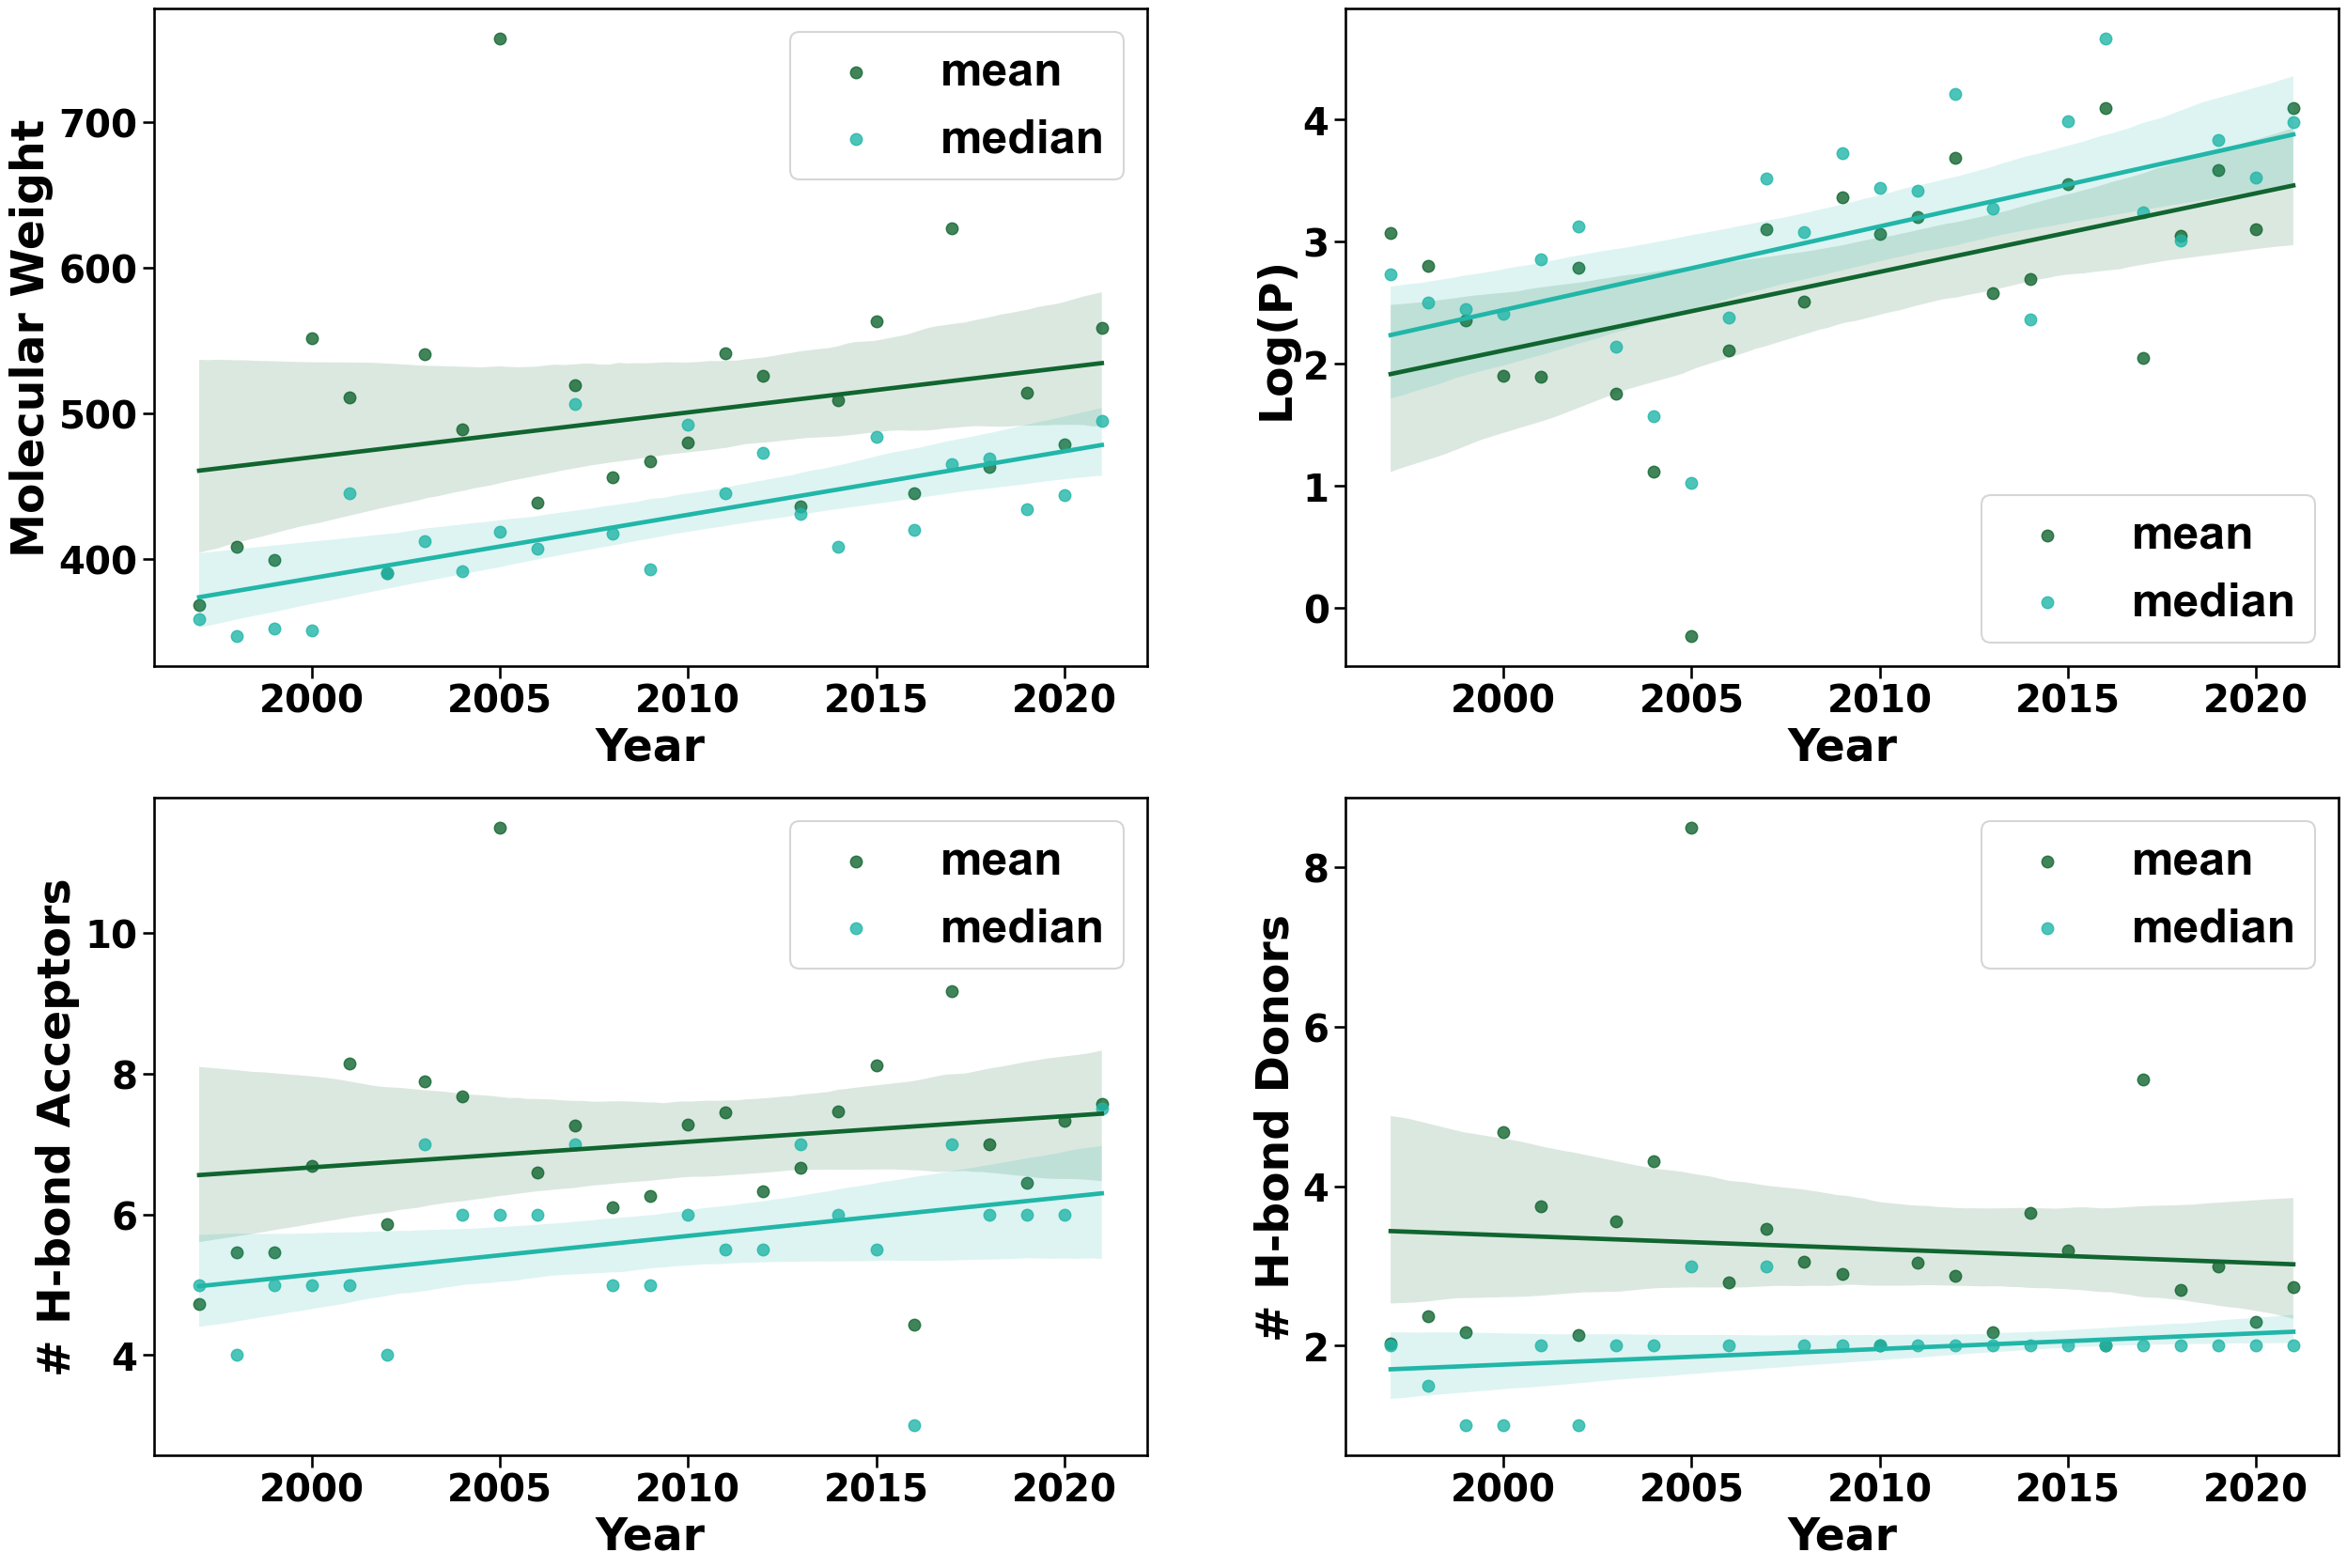

In [72]:
# creating image
fig, axs = plt.subplots(2, 2, figsize = (30,20))

# plotting graphs
parameter_by_year(parameter="mw", loc="upper right", fig=fig, ax=axs[0][0])
parameter_by_year(parameter="logp", loc="lower right", fig=fig, ax=axs[0][1])
parameter_by_year(parameter="n_hba", loc="upper right", fig=fig, ax=axs[1][0])
parameter_by_year(parameter="n_hbd", loc="upper right", fig=fig, ax=axs[1][1])

# saving img
fig.savefig(f"../imgs/lipinski/parameters_by_years.png", dpi=300)

In [85]:
def parameter_by_year2(parameter, loc, fig, ax):
    # creating a dataset with the mean and median of the parameter in each year
    df_years = pd.DataFrame(columns=["year", f"{parameter}_mean", f"{parameter}_median"])

    for year, df in df_groupby_year:
        df_years.loc[len(df_years)] = [year, df[parameter].mean(), df[parameter].median()]
    
    # creating models with simple linear regression for the mean and median
    X = df_years[["year"]]
    y_mean = df_years[[f"{parameter}_mean"]]
    y_median = df_years[f"{parameter}_median"]
    
    #model_mean_lr = LinearRegression().fit(X, y_mean)
    #model_median_lr = LinearRegression().fit(X, y_median)
    

    # plotting the mean and median of the parameter by each year
    # color variables
    color1 = '#116530'
    color2 = "#21B6A8"
    
    # plotting mean
    #sns.lineplot(x = 'year', y = f"{parameter}_mean", data = df_years, label="mean", color=color1, ax=ax)
    #ax.scatter(df_years["year"], df_years[f"{parameter}_mean"], s=250, color=color1)
    sns.regplot(x=X, y=y_mean, label="mean", ax=ax, color=color1, scatter_kws={"s": 300})
    
    #sns.regplot(x=X, y=y_median, label="median", ax=ax, color=color2)
    # plotting median
    #sns.lineplot(x = 'year', y = f"{parameter}_median", data = df_years, label="median", color=color2, ax=ax)
    #ax.scatter(df_years["year"], df_years[f"{parameter}_median"], s=250, color=color2)
    
    # setting labels
    y_label = change_parameter_name(parameter)
    x_label = "Year"
    ax.set_xlabel(x_label, fontsize=34, fontweight=1000)
    ax.set_ylabel(y_label, fontsize=34, fontweight=1000)

    # bold tick
    plt.setp(ax.get_xticklabels(), fontsize=29, fontweight=627)
    plt.setp(ax.get_yticklabels(), fontsize=29, fontweight=624)

    # legend
    font = matplotlib.font_manager.FontProperties(family="Arial", weight=1000, size=36)
    ax.legend(loc=loc, prop=font)
    
    # plotting the linear regressions
    #ax.plot(X, model_mean_lr.predict(X), color = color1, linestyle = '--', dashes=(8, 5))
    #ax.plot(X, model_median_lr.predict(X), color = color2, linestyle = '--', dashes=(8, 5))
    
    

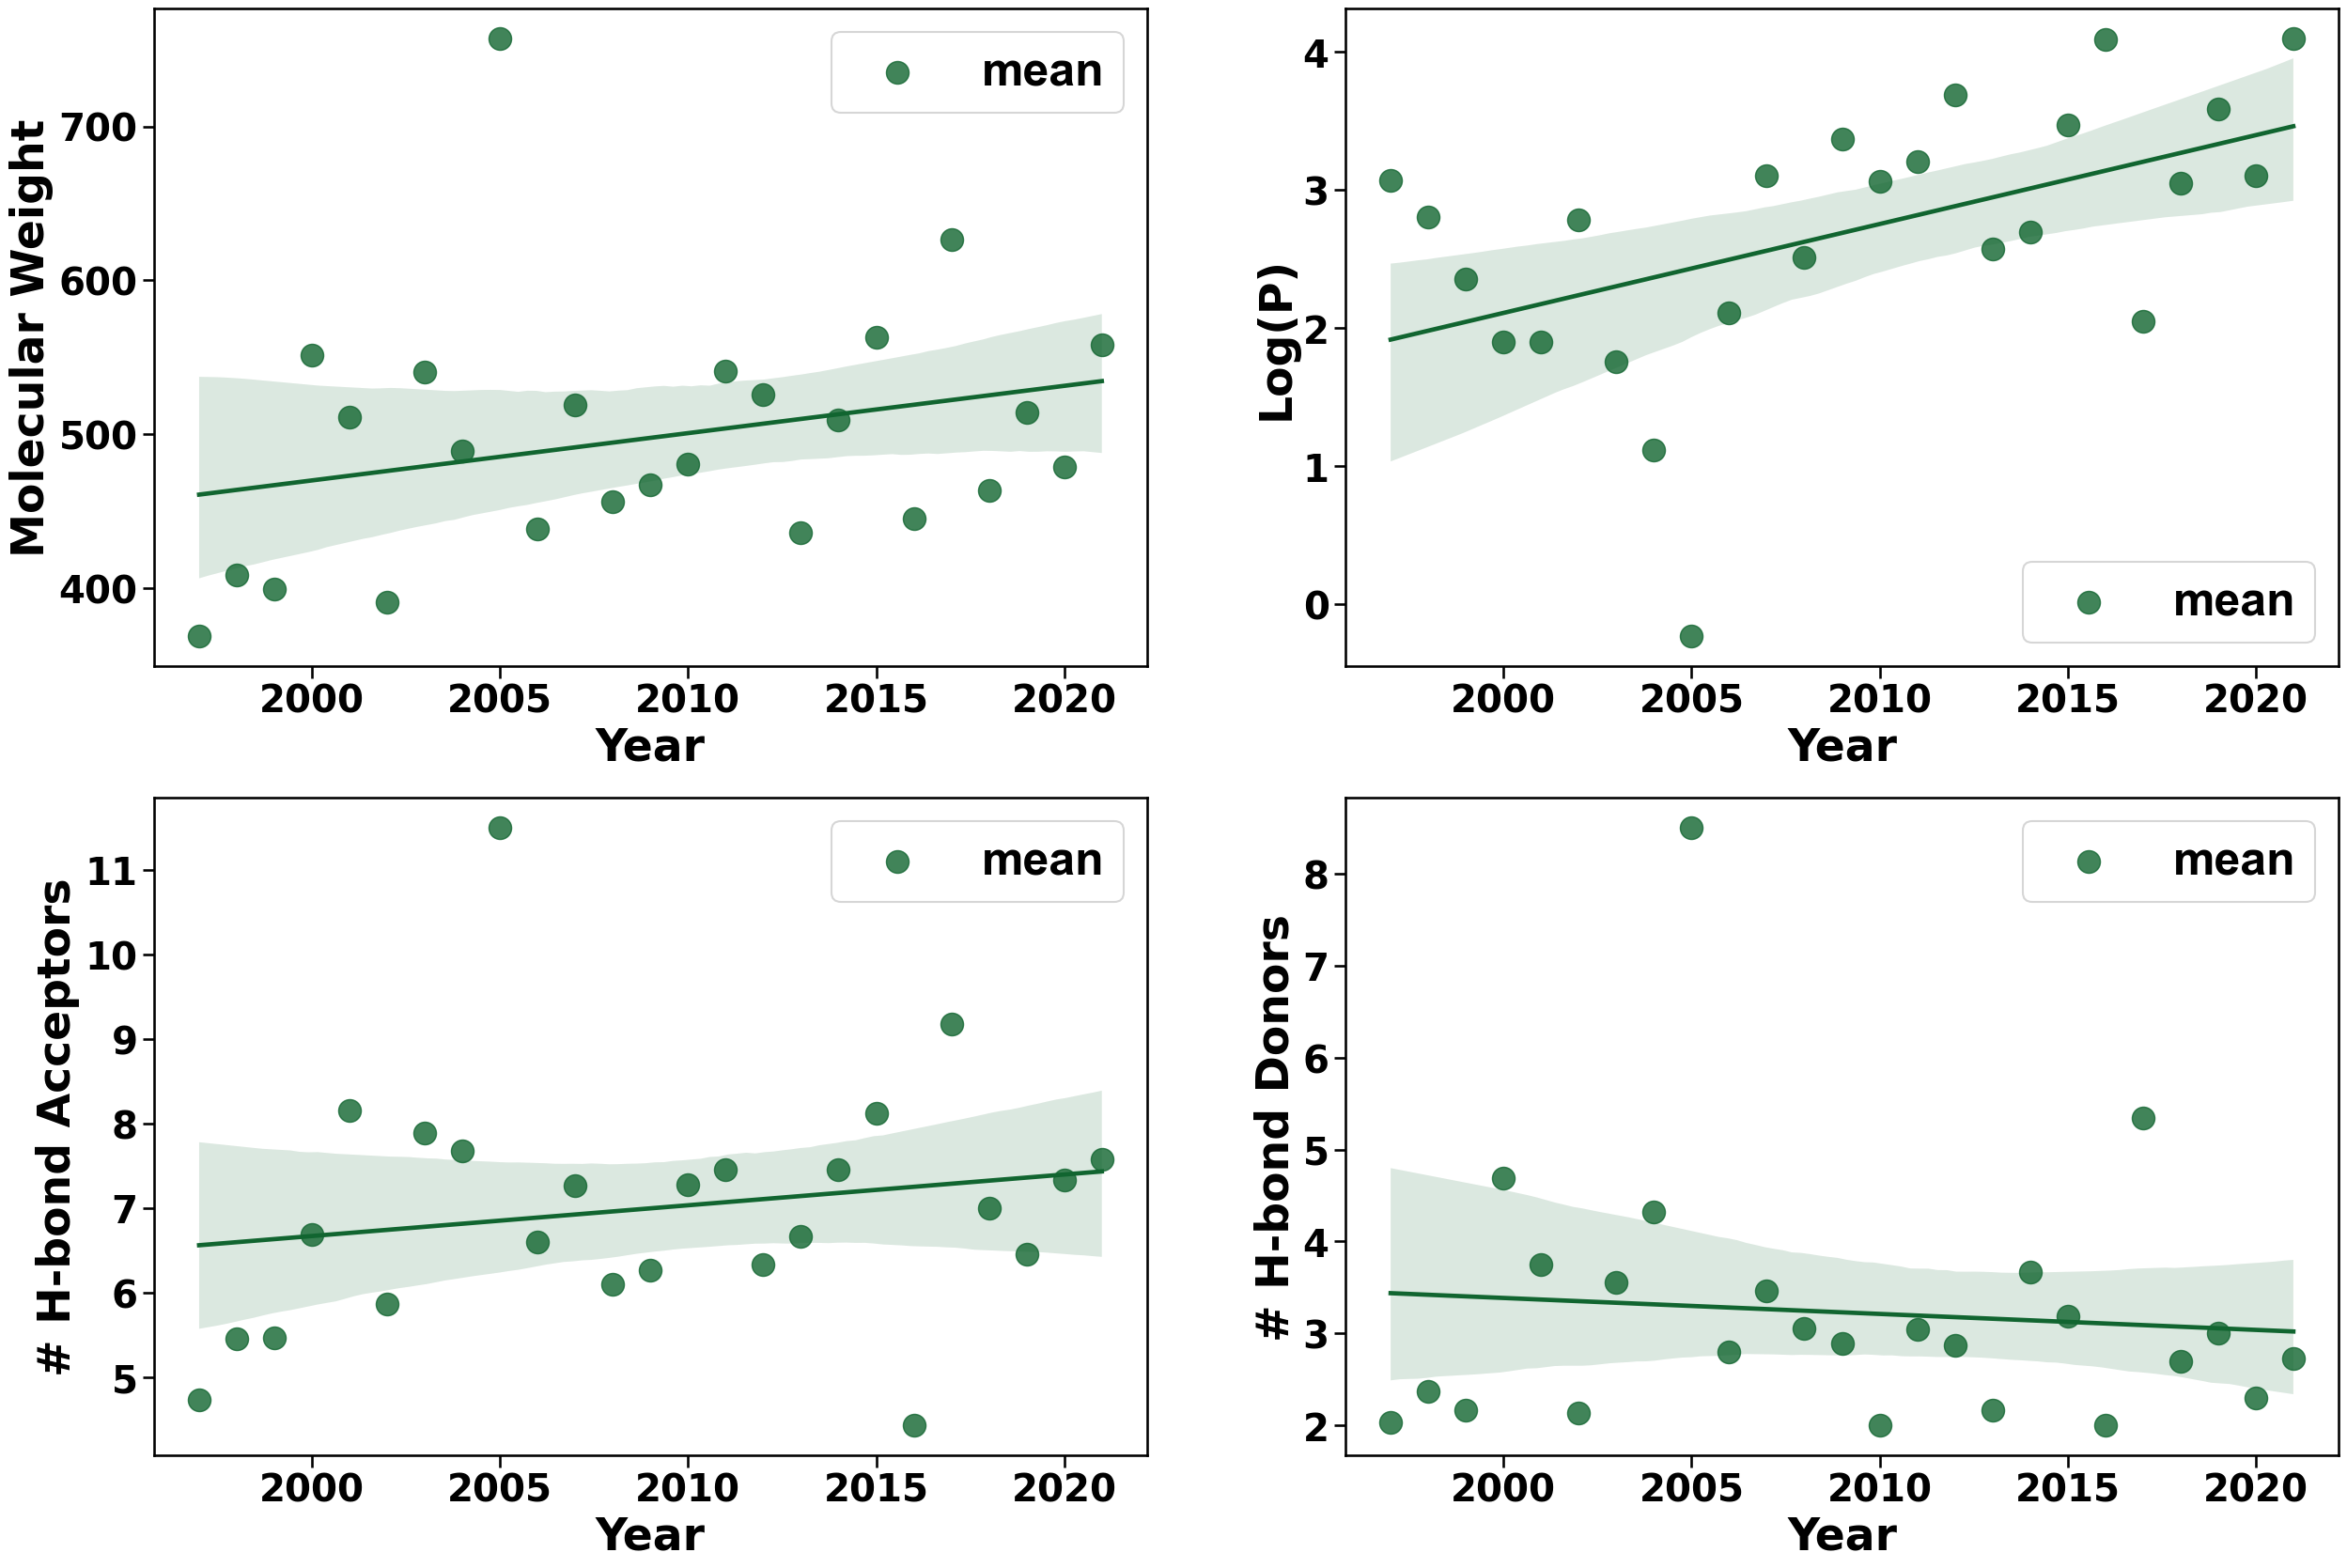

In [86]:
# creating image
fig, axs = plt.subplots(2, 2, figsize = (30,20))

# plotting graphs
parameter_by_year2(parameter="mw", loc="upper right", fig=fig, ax=axs[0][0])
parameter_by_year2(parameter="logp", loc="lower right", fig=fig, ax=axs[0][1])
parameter_by_year2(parameter="n_hba", loc="upper right", fig=fig, ax=axs[1][0])
parameter_by_year2(parameter="n_hbd", loc="upper right", fig=fig, ax=axs[1][1])

# saving img
fig.savefig(f"../imgs/lipinski/parameters_by_years2.png", dpi=300)

analysing 2005

In [ ]:
drugs_db_route_merged[drugs_db_route_merged["approval_year"] == 2005].drop(["ROMol", "Mol_Clean"], axis = 1)

In [ ]:
drugs_db_route_merged[drugs_db_route_merged["mw"] > 1000].drop(["ROMol", "Mol_Clean"], axis = 1)

Here are the libraries used:

In [ ]:
session_info.show()